In [ ]:
## CPU specs ##
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [ ]:
!cat /proc/meminfo

MemTotal:       13333556 kB
MemFree:        10530824 kB
MemAvailable:   12459492 kB
Buffers:           75956 kB
Cached:          2010204 kB
SwapCached:            0 kB
Active:           735188 kB
Inactive:        1786424 kB
Active(anon):     415112 kB
Inactive(anon):      340 kB
Active(file):     320076 kB
Inactive(file):  1786084 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               168 kB
Writeback:             0 kB
AnonPages:        435560 kB
Mapped:           222136 kB
Shmem:               964 kB
Slab:             167272 kB
SReclaimable:     126800 kB
SUnreclaim:        40472 kB
KernelStack:        3584 kB
PageTables:         5504 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666776 kB
Committed_AS:    2536576 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:              920 kB
AnonHugePages:   

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=fee3e5f8ee4509434434047815f437d32eaae660cd93c9db889818cdb003996a
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 111.3 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wHKHuXL_QKXSqTzjMvCEyeDkAHIo9J8vwV6cbojVVnL-7PYY3SpPi0
Mounted at /content/drive


In [ ]:
#############################################
## required to import custom modules in GC ##
import sys
sys.path.append('/content/drive/My Drive/PyTorchDIA - Real Image Tests')
##############################################

# grab photutils
#!pip install photutils

# other useful imports
import numpy as np
import os
import glob
from astropy.io.fits import getdata
from astropy.stats import mad_std
#from photutils import DAOStarFinder
import time
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage.interpolation import shift
from scipy.stats import norm
#import PyTorchDIA_FullLikelihood
import PyTorchDIA_RobustLoss_lossconv
import torch
%matplotlib inline

PyTorch version: 1.6.0+cu101


In [ ]:
### pyDANDIA ###
%load_ext Cython

In [ ]:
%%cython

from __future__ import division
import numpy as np
import time
cimport numpy as np
cimport cython
DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

# compile suggestion: gcc -shared -pthread -fPIC -fwrapv -O2 -Wall -fno-strict-aliasing -I/somepath/include/python2.7 -o umatrix_routine.so umatrix_routine.c

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
@cython.nonecheck(False)  # turn off negative index wrapping

def umatrix_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(reference_image)[0]
    cdef int nj_image = np.shape(reference_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
    cdef np.ndarray u_matrix = np.zeros([n_kernel + 1, n_kernel + 1], dtype=DTYPE)

    for idx_p in range(n_kernel):
        for idx_q in range(idx_p,n_kernel):
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * reference_image[idx_i + idx_l_prime,idx_j + idx_m_prime]  * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
            u_matrix[idx_q, idx_p] = sum_acc

    for idx_p in [n_kernel]:
        for idx_q in range(n_kernel):
            sum_acc = 0.
            idx_l = kernel_size
            idx_m = kernel_size
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l_prime, idx_j + idx_m_prime] * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
    
    for idx_p in range(n_kernel):
        for idx_q in [n_kernel]:
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime = kernel_size
            idl_m_prime = kernel_size
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half, nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * weights[idx_i, idx_j] 
            u_matrix[idx_p, idx_q] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += weights[idx_i, idx_j] 
    u_matrix[n_kernel, n_kernel] = sum_acc
    
    return u_matrix

def bvector_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] data_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(data_image)[0]
    cdef int nj_image = np.shape(data_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
        
    cdef np.ndarray b_vector = np.zeros([n_kernel + 1], dtype=DTYPE)
    for idx_p in range(n_kernel):
        idx_l, idx_m = pandq[idx_p]
        sum_acc = 0.
        for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
            for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                   sum_acc += data_image[idx_i, idx_j] * reference_image[idx_i + idx_l , idx_j + idx_m ] * weights[idx_i, idx_j]
        b_vector[idx_p] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += data_image[idx_i, idx_j] * weights[idx_i, idx_j]
    b_vector[n_kernel] = sum_acc

    return b_vector


## Specify all the functions required ##

def extend_image(image, kernel_size):
    image_extended = np.zeros((np.shape(image)[0] + 2 * kernel_size,
                             np.shape(image)[1] + 2 * kernel_size))
    image_extended[kernel_size:-kernel_size, kernel_size:-kernel_size] = np.array(image, float)
    
    return image_extended

# function to build the kernel, U matrix and b vector
def construct_kernel_and_matrices(kernel_size, R, I, weights):

    pandq = []
    n_kernel = kernel_size * kernel_size
    ncount = 0
    half_kernel_size = int(int(kernel_size) / 2)
    for lidx in range(kernel_size):
        for midx in range(kernel_size):
            pandq.append((lidx - half_kernel_size, midx - half_kernel_size))


    R = R.astype('float64')
    I =  I.astype('float64')
    weights = weights.astype('float64')

    start_time = time.time()
    U = umatrix_construction(R, weights, pandq, n_kernel, kernel_size)
    b = bvector_construction(R, I, weights, pandq, n_kernel, kernel_size)
    print("--- Finished U and b construction in %s seconds ---" % (time.time() - start_time))
    return U, b


# define a function for the least-squares solution
def lstsq_solution(R, I, U, b, kernel_size):
    
    lstsq_result = np.linalg.lstsq(np.array(U), np.array(b), rcond=None)
    a_vector = lstsq_result[0]
    lstsq_fit = np.dot(np.array(U), a_vector)
    resid = np.array(b) - lstsq_fit
    reduced_chisqr = np.sum(resid ** 2) / (float(kernel_size * kernel_size))
    lstsq_cov = np.dot(np.array(U).T, np.array(U)) * reduced_chisqr
    resivar = np.var(resid, ddof=0) * float(len(a_vector))
    
    # use pinv in order to stabilize calculation
    a_var = np.diag(np.linalg.pinv(lstsq_cov) * resivar)

    a_vector_err = np.sqrt(a_var)
    output_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        output_kernel = a_vector[:-1]
    else:
        output_kernel = a_vector
    output_kernel = output_kernel.reshape((kernel_size, kernel_size))

    err_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        err_kernel = a_vector_err[:-1]
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))
    else:
        err_kernel = a_vector_err
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))

    output_kernel_2 = np.flip(np.flip(output_kernel, 0), 1)
    err_kernel_2 = np.flip(np.flip(err_kernel, 0), 1)
    bkg_kernel = a_vector[-1]
    output_kernel_2.shape

    return output_kernel_2, bkg_kernel

In [ ]:
## load images, reference and master flat ##
## this can take a while in colab

## path to images
path = '/content/drive/My Drive/PyTorchDIA - Real Image Tests/LOB190560Z'

## reference
ref_file = os.path.join(path, 'coll_LOB190560Z_Llr_2019-05-14_00129.fits')
ref_data = getdata(ref_file, header=True)
ref, ref_fwhm = ref_data[0], ref_data[1]['FWHM']
print(ref_fwhm)

## master flat
flat_file = os.path.join(path, 'master_flat.fits')
master_flat = getdata(flat_file, 0, header=True)[0]

## shifts
shift_info = os.path.join(path, 'Shift_info.txt')
shifts = np.genfromtxt(shift_info, delimiter="\t", dtype=str) # filename | xs | ys

## crop reference and master flat ##
crop = 150
ref = ref[crop:ref.shape[0]-crop, crop:ref.shape[1]-crop]
#master_flat = master_flat[crop:master_flat.shape[0]-crop, crop:master_flat.shape[1]-crop]


## ensure dtype=np.float32
ref = np.array(ref, dtype=np.float32)
master_flat = np.array(master_flat, dtype=np.float32)

fnames = []
images = []
FWHMs = []
N_images = []

for image_file in glob.glob(os.path.join(path, "*coll*")):
  # avoid reference
  if ref_file not in image_file:
    fnames.append(image_file.split('/')[-1])
    print(image_file.split('/')[-1])
    image_data = getdata(image_file, header=True)
    image, header = image_data[0], image_data[1]
    image = image[crop:image.shape[0]-crop, crop:image.shape[1]-crop]
    ## apply any crops to image border ##
    images.append(image)
    FWHMs.append(header['FWHM'])
    N_images.append(header['TOT_IM'])

# convert to numpy arrays (float32)
images, FWHMs = np.array(images, dtype=np.float32), np.array(FWHMs)

print(ref.shape, master_flat.shape, images.shape)
print('Max x shift:', np.max(shifts[:,2].astype(float)))
print('Max y shift:', np.max(shifts[:,1].astype(float)))
print(np.median(FWHMs))

4.292310021996962
coll_LOB190560Z_Llr_2019-05-15_00099.fits
coll_LOB190560Z_Llr_2019-05-12_00055.fits
coll_LOB190560Z_Llr_2019-05-13_00098.fits
coll_LOB190560Z_Llr_2019-05-16_00078.fits
coll_LOB190560Z_Llr_2019-05-14_00100.fits
coll_LOB190560Z_Llr_2019-05-15_00002.fits
coll_LOB190560Z_Llr_2019-05-15_00089.fits
coll_LOB190560Z_Llr_2019-05-12_00029.fits
coll_LOB190560Z_Llr_2019-05-12_00078.fits
coll_LOB190560Z_Llr_2019-05-15_00116.fits
coll_LOB190560Z_Llr_2019-05-14_00069.fits
coll_LOB190560Z_Llr_2019-05-15_00111.fits
coll_LOB190560Z_Llr_2019-05-15_00035.fits
coll_LOB190560Z_Llr_2019-05-15_00087.fits
coll_LOB190560Z_Llr_2019-05-15_00041.fits
coll_LOB190560Z_Llr_2019-05-12_00058.fits
coll_LOB190560Z_Llr_2019-05-10_00108.fits
coll_LOB190560Z_Llr_2019-05-15_00039.fits
coll_LOB190560Z_Llr_2019-05-14_00121.fits
coll_LOB190560Z_Llr_2019-05-14_00112.fits
coll_LOB190560Z_Llr_2019-05-14_00187.fits
coll_LOB190560Z_Llr_2019-05-12_00059.fits
coll_LOB190560Z_Llr_2019-05-14_00192.fits
coll_LOB190560Z_

Image 0 of 158
FWHM: 7.208181909203837
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 3
--- Time to move data onto GPU: 0.000400543212890625 ---
Switching to Quasi-Newton step after 226 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4317145347595215 seconds ---
Parameter containing:
tensor([2609.0400], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0593, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2609.0400390625


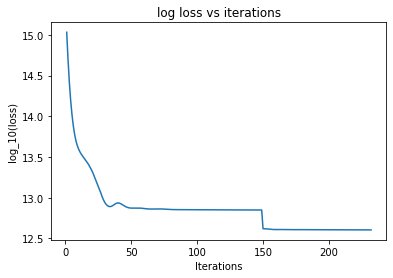

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5668601989746094 seconds ---
SNR: 354.2835
Image 1 of 158
FWHM: 8.237368801564449
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 -3
--- Time to move data onto GPU: 0.00032806396484375 ---
Switching to Quasi-Newton step after 358 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.9221596717834473 seconds ---
Parameter containing:
tensor([2142.3857], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9606, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2142.3857421875


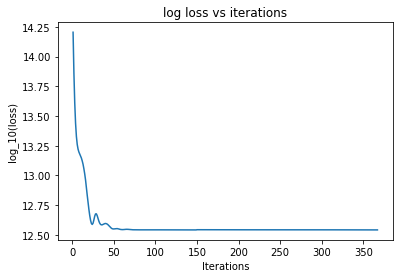

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.0559492111206055 seconds ---
SNR: 249.35168
Image 2 of 158
FWHM: 6.610971295785458
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 13
--- Time to move data onto GPU: 0.00037789344787597656 ---
Switching to Quasi-Newton step after 205 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5460331439971924 seconds ---
Parameter containing:
tensor([2213.2205], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9124, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2213.220458984375


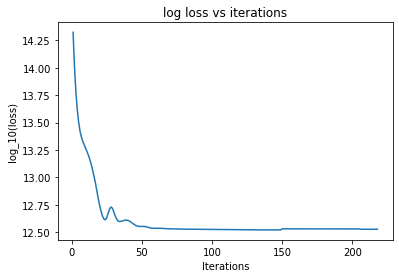

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.677196979522705 seconds ---
SNR: 262.72357
Image 3 of 158
FWHM: 9.629508459320077
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 -4
--- Time to move data onto GPU: 0.00043511390686035156 ---
Switching to Quasi-Newton step after 223 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4941046237945557 seconds ---
Parameter containing:
tensor([2919.1218], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.7941, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2919.121826171875


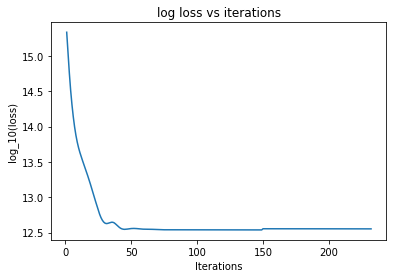

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6125860214233398 seconds ---
SNR: 166.41434
Image 4 of 158
FWHM: 6.128724846985156
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 6
--- Time to move data onto GPU: 0.0003349781036376953 ---
Switching to Quasi-Newton step after 342 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.0327818393707275 seconds ---
Parameter containing:
tensor([2324.4565], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9512, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2324.45654296875


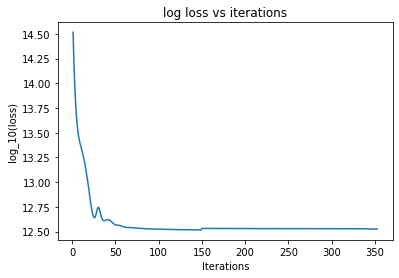

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.173264265060425 seconds ---
SNR: 278.28827
Image 5 of 158
FWHM: 9.784816284668382
N images: 1200.0
Aligning flat with (xs, ys) shifts: 4 9
--- Time to move data onto GPU: 0.0003330707550048828 ---
Switching to Quasi-Newton step after 221 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.500812292098999 seconds ---
Parameter containing:
tensor([2624.8643], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9005, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2624.8642578125


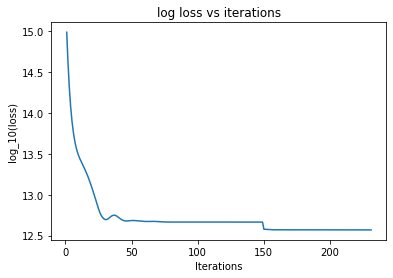

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6182377338409424 seconds ---
SNR: 237.65115
Image 6 of 158
FWHM: 7.581018581193582
N images: 1200.0
Aligning flat with (xs, ys) shifts: 6 4
--- Time to move data onto GPU: 0.0003495216369628906 ---
Switching to Quasi-Newton step after 208 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6052579879760742 seconds ---
Parameter containing:
tensor([2789.4424], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0573, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2789.4423828125


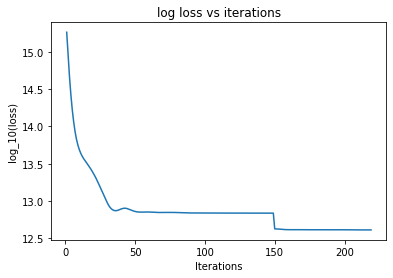

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7248127460479736 seconds ---
SNR: 322.48718
Image 7 of 158
FWHM: 5.923022577920849
N images: 1200.0
Aligning flat with (xs, ys) shifts: 4 5
--- Time to move data onto GPU: 0.0003833770751953125 ---
Switching to Quasi-Newton step after 388 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.1742961406707764 seconds ---
Parameter containing:
tensor([2152.7551], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9860, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2152.755126953125


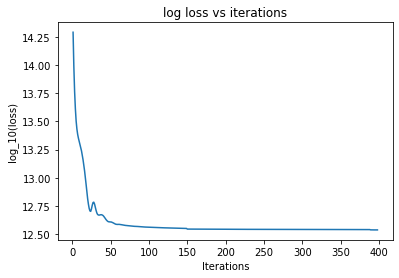

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.3085882663726807 seconds ---
SNR: 290.40396
Image 8 of 158
FWHM: 7.470050458925156
N images: 1200.0
Aligning flat with (xs, ys) shifts: 5 8
--- Time to move data onto GPU: 0.00037741661071777344 ---
Switching to Quasi-Newton step after 206 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6653778553009033 seconds ---
Parameter containing:
tensor([2256.3796], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9706, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2256.379638671875


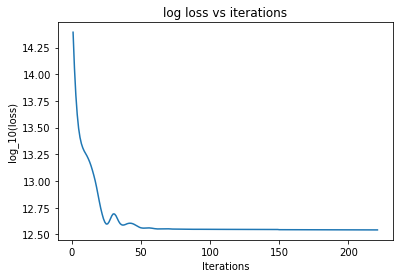

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.790358066558838 seconds ---
SNR: 255.67928
Image 9 of 158
FWHM: 9.053990046317159
N images: 1200.0
Aligning flat with (xs, ys) shifts: 5 2
--- Time to move data onto GPU: 0.00033783912658691406 ---
Switching to Quasi-Newton step after 217 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5553534030914307 seconds ---
Parameter containing:
tensor([2734.4873], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9874, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2734.4873046875


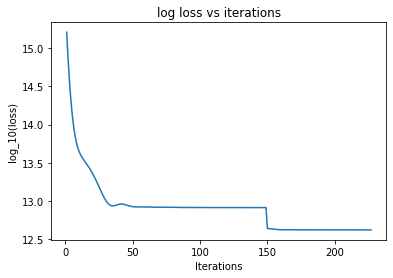

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6798076629638672 seconds ---
SNR: 313.17422
Image 10 of 158
FWHM: 7.119017144003217
N images: 1200.0
Aligning flat with (xs, ys) shifts: -5 5
--- Time to move data onto GPU: 0.0004374980926513672 ---
Switching to Quasi-Newton step after 224 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5586299896240234 seconds ---
Parameter containing:
tensor([2442.8640], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9234, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2442.864013671875


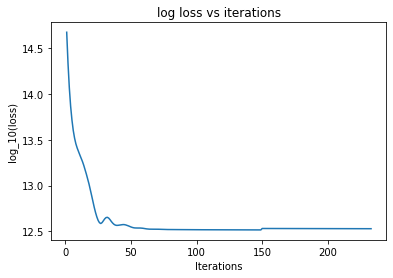

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.683584451675415 seconds ---
SNR: 248.85909
Image 11 of 158
FWHM: 9.418892835681044
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 -4
--- Time to move data onto GPU: 0.0003674030303955078 ---
Switching to Quasi-Newton step after 219 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4485275745391846 seconds ---
Parameter containing:
tensor([2633.1841], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9722, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2633.18408203125


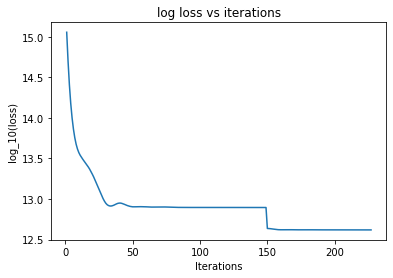

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.574531078338623 seconds ---
SNR: 308.70343
Image 12 of 158
FWHM: 8.330184880898496
N images: 1200.0
Aligning flat with (xs, ys) shifts: 0 8
--- Time to move data onto GPU: 0.0004820823669433594 ---
Switching to Quasi-Newton step after 205 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4953281879425049 seconds ---
Parameter containing:
tensor([2518.4460], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9253, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2518.446044921875


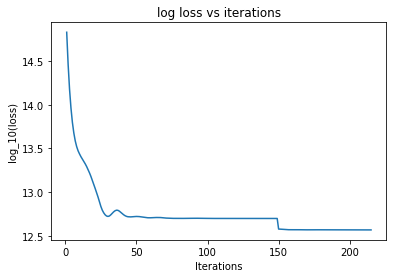

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6261181831359863 seconds ---
SNR: 273.36096
Image 13 of 158
FWHM: 8.519200254253198
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 0
--- Time to move data onto GPU: 0.0003235340118408203 ---
Switching to Quasi-Newton step after 326 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.759805679321289 seconds ---
Parameter containing:
tensor([2796.4453], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0113, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2796.4453125


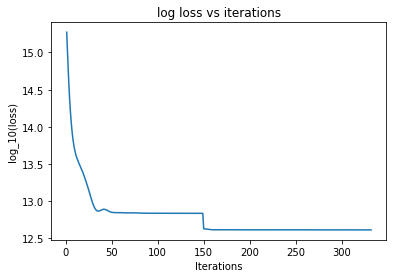

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.8883905410766602 seconds ---
SNR: 294.75156
Image 14 of 158
FWHM: 8.224922616031238
N images: 1200.0
Aligning flat with (xs, ys) shifts: 6 7
--- Time to move data onto GPU: 0.0003528594970703125 ---
Switching to Quasi-Newton step after 286 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6438908576965332 seconds ---
Parameter containing:
tensor([2520.9265], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9255, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2520.926513671875


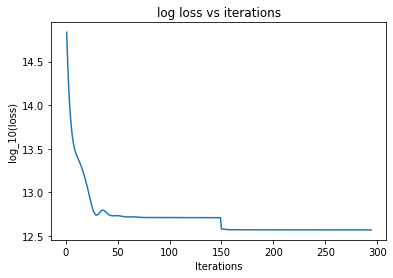

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.8944120407104492 seconds ---
SNR: 271.37988
Image 15 of 158
FWHM: 8.272091296325327
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 3
--- Time to move data onto GPU: 0.0003528594970703125 ---
Switching to Quasi-Newton step after 330 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7456035614013672 seconds ---
Parameter containing:
tensor([2127.8215], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9565, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2127.821533203125


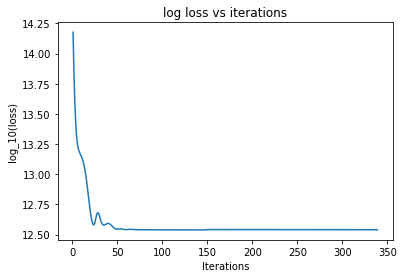

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.8800716400146484 seconds ---
SNR: 248.91942
Image 16 of 158
FWHM: 6.487499927432229
N images: 1200.0
Aligning flat with (xs, ys) shifts: -4 0
--- Time to move data onto GPU: 0.0003757476806640625 ---
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 0.9166264533996582 seconds ---
Parameter containing:
tensor([2357.3005], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9717, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2357.300537109375


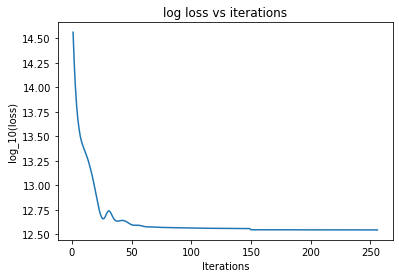

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.0478196144104004 seconds ---
SNR: 268.30377
Image 17 of 158
FWHM: 8.25529149224719
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 9
--- Time to move data onto GPU: 0.0004611015319824219 ---
Switching to Quasi-Newton step after 208 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.490527629852295 seconds ---
Parameter containing:
tensor([2536.9202], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9206, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2536.920166015625


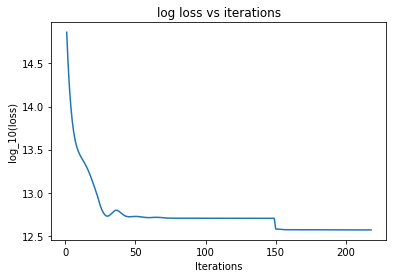

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6094226837158203 seconds ---
SNR: 269.9502
Image 18 of 158
FWHM: 4.751758787370663
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 -5
--- Time to move data onto GPU: 0.00045418739318847656 ---
Switching to Quasi-Newton step after 579 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.9854555130004883 seconds ---
Parameter containing:
tensor([2225.9893], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9849, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2225.9892578125


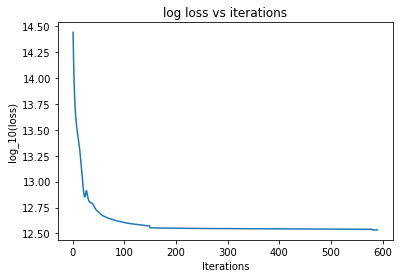

This version does not print parameter values vs iterations yet!
--- Finished in a total of 3.1236469745635986 seconds ---
SNR: 331.4722
Image 19 of 158
FWHM: 5.269923066012474
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 -5
--- Time to move data onto GPU: 0.0003197193145751953 ---
Switching to Quasi-Newton step after 442 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.25288462638855 seconds ---
Parameter containing:
tensor([2254.0974], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9673, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2254.097412109375


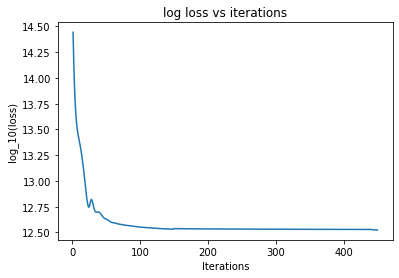

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.391162872314453 seconds ---
SNR: 305.35904
Image 20 of 158
FWHM: 6.391414174242552
N images: 1200.0
Aligning flat with (xs, ys) shifts: 0 3
--- Time to move data onto GPU: 0.000324249267578125 ---
Switching to Quasi-Newton step after 201 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5240261554718018 seconds ---
Parameter containing:
tensor([2511.1099], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9286, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2511.10986328125


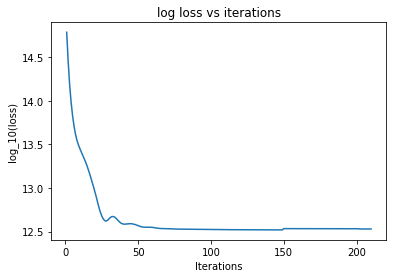

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6481037139892578 seconds ---
SNR: 252.11026
Image 21 of 158
FWHM: 7.795444815047687
N images: 1200.0
Aligning flat with (xs, ys) shifts: -4 -1
--- Time to move data onto GPU: 0.0003712177276611328 ---
Switching to Quasi-Newton step after 201 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.3975193500518799 seconds ---
Parameter containing:
tensor([2104.3657], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9662, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2104.36572265625


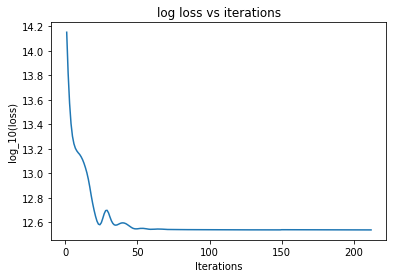

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5226786136627197 seconds ---
SNR: 256.10974
Image 22 of 158
FWHM: 6.493862398152404
N images: 1200.0
Aligning flat with (xs, ys) shifts: 0 -4
--- Time to move data onto GPU: 0.00042700767517089844 ---
Switching to Quasi-Newton step after 224 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4663760662078857 seconds ---
Parameter containing:
tensor([2501.2717], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9158, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2501.271728515625


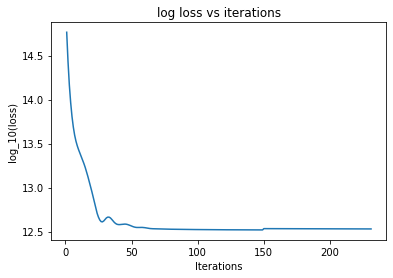

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5896639823913574 seconds ---
SNR: 247.86359
Image 23 of 158
FWHM: 8.83139093528102
N images: 1200.0
Aligning flat with (xs, ys) shifts: -2 3
--- Time to move data onto GPU: 0.0003273487091064453 ---
Switching to Quasi-Newton step after 213 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5412859916687012 seconds ---
Parameter containing:
tensor([2624.4746], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8830, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2624.474609375


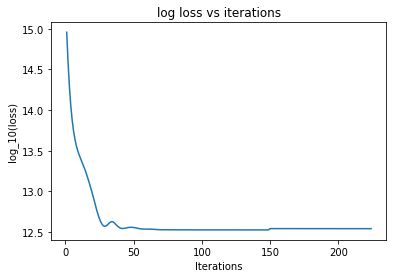

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6609504222869873 seconds ---
SNR: 206.48001
Image 24 of 158
FWHM: 7.82041000274993
N images: 1200.0
Aligning flat with (xs, ys) shifts: 5 -6
--- Time to move data onto GPU: 0.0003714561462402344 ---
Switching to Quasi-Newton step after 216 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.3892204761505127 seconds ---
Parameter containing:
tensor([2652.4634], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9659, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2652.46337890625


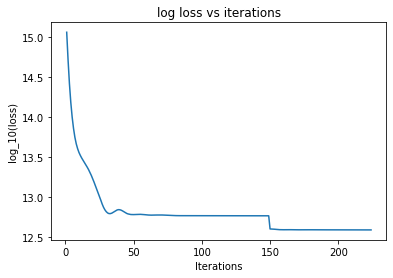

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5120513439178467 seconds ---
SNR: 286.2801
Image 25 of 158
FWHM: 4.548457776416356
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 6
--- Time to move data onto GPU: 0.00032830238342285156 ---
Switching to Quasi-Newton step after 643 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.248884916305542 seconds ---
Parameter containing:
tensor([2233.3218], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0025, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2233.32177734375


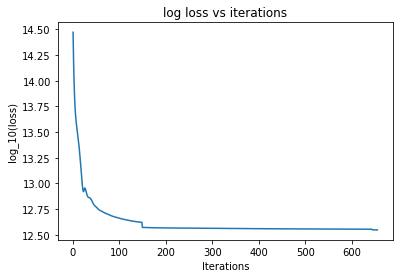

This version does not print parameter values vs iterations yet!
--- Finished in a total of 3.3890771865844727 seconds ---
SNR: 343.8358
Image 26 of 158
FWHM: 4.460898683501727
N images: 1200.0
Aligning flat with (xs, ys) shifts: -10 5
--- Time to move data onto GPU: 0.0003364086151123047 ---
Switching to Quasi-Newton step after 776 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.7658534049987793 seconds ---
Parameter containing:
tensor([2277.5125], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9910, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2277.512451171875


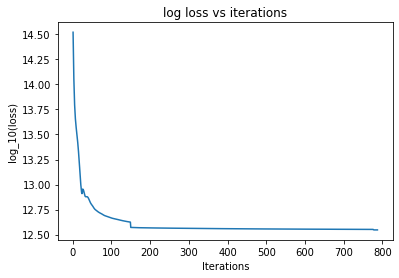

This version does not print parameter values vs iterations yet!
--- Finished in a total of 3.914849042892456 seconds ---
SNR: 337.42825
Image 27 of 158
FWHM: 8.373306330221148
N images: 1200.0
Aligning flat with (xs, ys) shifts: -3 4
--- Time to move data onto GPU: 0.0003745555877685547 ---
Switching to Quasi-Newton step after 256 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4946792125701904 seconds ---
Parameter containing:
tensor([2245.0518], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9282, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2245.0517578125


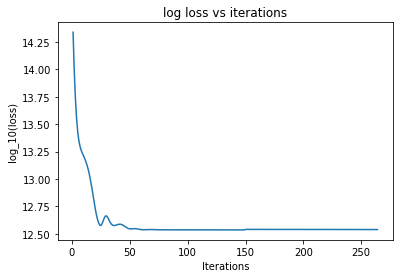

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6219189167022705 seconds ---
SNR: 235.14197
Image 28 of 158
FWHM: 7.475952815567578
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 -2
--- Time to move data onto GPU: 0.00043320655822753906 ---
Switching to Quasi-Newton step after 219 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5163052082061768 seconds ---
Parameter containing:
tensor([2501.0613], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9370, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2501.061279296875


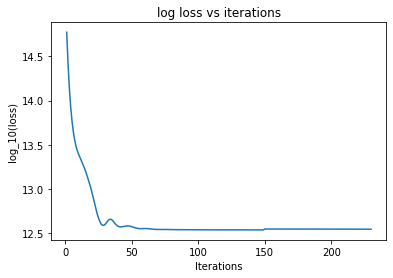

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6335883140563965 seconds ---
SNR: 244.3212
Image 29 of 158
FWHM: 8.94915287801914
N images: 1200.0
Aligning flat with (xs, ys) shifts: -2 3
--- Time to move data onto GPU: 0.00034689903259277344 ---
Switching to Quasi-Newton step after 220 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5782341957092285 seconds ---
Parameter containing:
tensor([2337.8059], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9288, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2337.805908203125


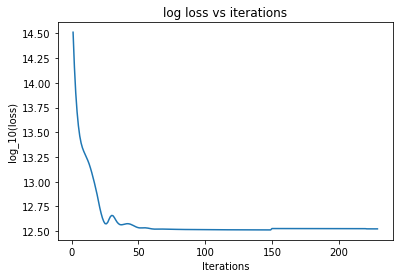

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7090377807617188 seconds ---
SNR: 253.98528
Image 30 of 158
FWHM: 8.53654707979012
N images: 1200.0
Aligning flat with (xs, ys) shifts: 4 1
--- Time to move data onto GPU: 0.0004150867462158203 ---
Switching to Quasi-Newton step after 206 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4505760669708252 seconds ---
Parameter containing:
tensor([2635.6846], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0226, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2635.6845703125


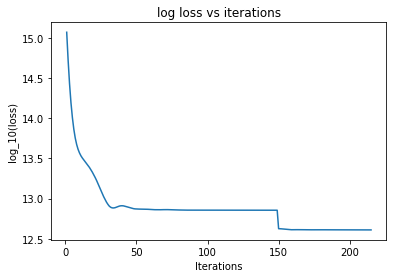

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5705053806304932 seconds ---
SNR: 316.70963
Image 31 of 158
FWHM: 8.801577986962842
N images: 1200.0
Aligning flat with (xs, ys) shifts: 6 6
--- Time to move data onto GPU: 0.0003204345703125 ---
Switching to Quasi-Newton step after 212 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4712417125701904 seconds ---
Parameter containing:
tensor([2526.0623], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9068, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2526.062255859375


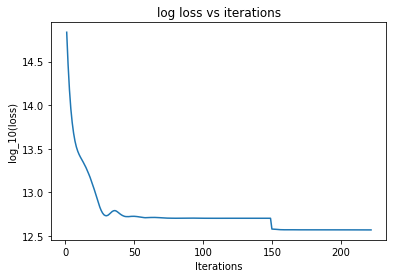

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5950520038604736 seconds ---
SNR: 260.57263
Image 32 of 158
FWHM: 5.620278150335433
N images: 1199.0
Aligning flat with (xs, ys) shifts: -1 -3
--- Time to move data onto GPU: 0.0003952980041503906 ---
Switching to Quasi-Newton step after 406 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.2558512687683105 seconds ---
Parameter containing:
tensor([2443.2175], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9971, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2443.217529296875


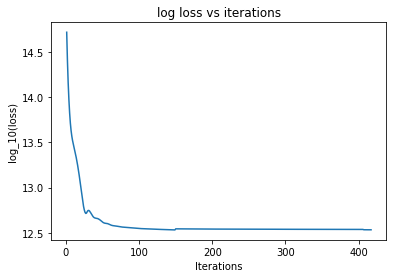

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.377908229827881 seconds ---
SNR: 291.08014
Image 33 of 158
FWHM: 5.422176911679276
N images: 1200.0
Aligning flat with (xs, ys) shifts: 0 4
--- Time to move data onto GPU: 0.0006041526794433594 ---
Switching to Quasi-Newton step after 307 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.0454249382019043 seconds ---
Parameter containing:
tensor([2134.4397], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9981, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2134.439697265625


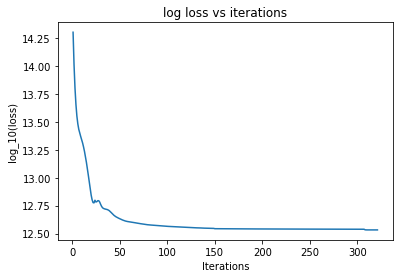

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.1764304637908936 seconds ---
SNR: 314.24826
Image 34 of 158
FWHM: 9.006763459342842
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 6
--- Time to move data onto GPU: 0.0004818439483642578 ---
Switching to Quasi-Newton step after 224 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5100901126861572 seconds ---
Parameter containing:
tensor([2673.2351], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8758, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2673.235107421875


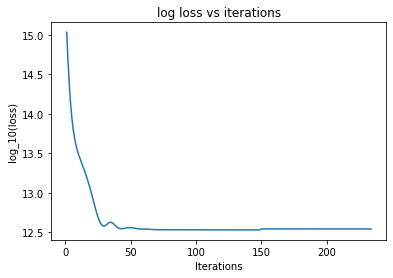

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6399736404418945 seconds ---
SNR: 198.75279
Image 35 of 158
FWHM: 8.552796740834966
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 0
--- Time to move data onto GPU: 0.0003268718719482422 ---
Switching to Quasi-Newton step after 254 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.569922924041748 seconds ---
Parameter containing:
tensor([2274.7883], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9202, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2274.788330078125


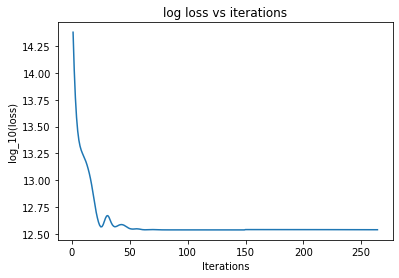

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6974971294403076 seconds ---
SNR: 229.53172
Image 36 of 158
FWHM: 6.415450079619223
N images: 1200.0
Aligning flat with (xs, ys) shifts: -2 9
--- Time to move data onto GPU: 0.0003223419189453125 ---
Switching to Quasi-Newton step after 227 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6348960399627686 seconds ---
Parameter containing:
tensor([2460.4583], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9525, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2460.458251953125


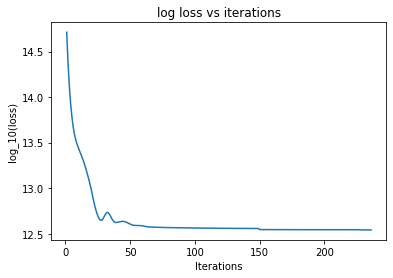

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.756030559539795 seconds ---
SNR: 254.44331
Image 37 of 158
FWHM: 5.598047453240849
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 -1
--- Time to move data onto GPU: 0.0003559589385986328 ---
Switching to Quasi-Newton step after 320 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.0661158561706543 seconds ---
Parameter containing:
tensor([2403.8496], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9917, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2403.849609375


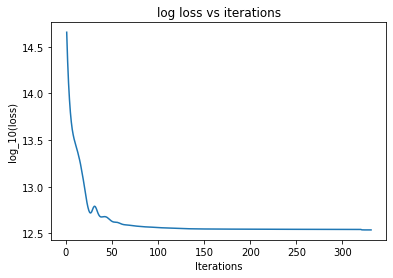

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.321925163269043 seconds ---
SNR: 292.02597
Image 38 of 158
FWHM: 8.485986358224926
N images: 1200.0
Aligning flat with (xs, ys) shifts: 7 6
--- Time to move data onto GPU: 0.0003676414489746094 ---
Switching to Quasi-Newton step after 251 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.613558292388916 seconds ---
Parameter containing:
tensor([2550.6123], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9113, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2550.6123046875


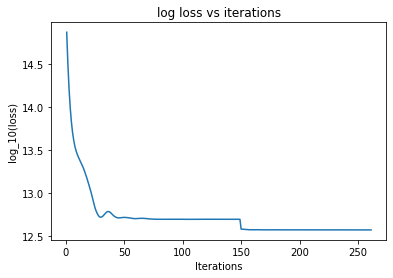

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7385578155517578 seconds ---
SNR: 261.31555
Image 39 of 158
FWHM: 5.69903596772865
N images: 1200.0
Aligning flat with (xs, ys) shifts: -5 -9
--- Time to move data onto GPU: 0.0003457069396972656 ---
Switching to Quasi-Newton step after 319 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.0332202911376953 seconds ---
Parameter containing:
tensor([2519.1816], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9289, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2519.181640625


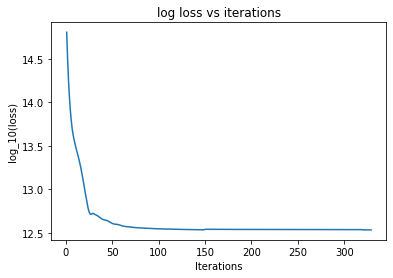

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.1569061279296875 seconds ---
SNR: 266.27325
Image 40 of 158
FWHM: 7.983983658046955
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 3
--- Time to move data onto GPU: 0.0003330707550048828 ---
Switching to Quasi-Newton step after 201 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4407858848571777 seconds ---
Parameter containing:
tensor([2236.8333], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8771, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2236.833251953125


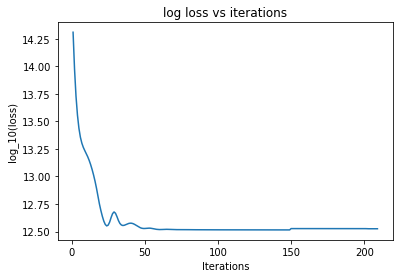

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5671722888946533 seconds ---
SNR: 233.02109
Image 41 of 158
FWHM: 6.306359966265891
N images: 1200.0
Aligning flat with (xs, ys) shifts: -8 -2
--- Time to move data onto GPU: 0.00032591819763183594 ---
Switching to Quasi-Newton step after 241 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5000636577606201 seconds ---
Parameter containing:
tensor([2344.1470], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9967, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2344.14697265625


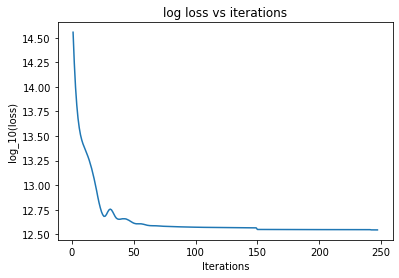

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6514575481414795 seconds ---
SNR: 275.76825
Image 42 of 158
FWHM: 8.710681077724411
N images: 1200.0
Aligning flat with (xs, ys) shifts: 5 9
--- Time to move data onto GPU: 0.0003669261932373047 ---
Switching to Quasi-Newton step after 204 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.421095848083496 seconds ---
Parameter containing:
tensor([2616.9341], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8884, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2616.93408203125


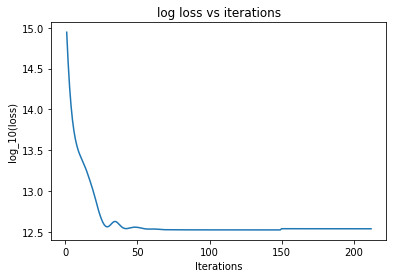

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5455925464630127 seconds ---
SNR: 207.59055
Image 43 of 158
FWHM: 9.861538704582443
N images: 1200.0
Aligning flat with (xs, ys) shifts: 6 7
--- Time to move data onto GPU: 0.00031948089599609375 ---
Switching to Quasi-Newton step after 210 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.679466962814331 seconds ---
Parameter containing:
tensor([2612.2253], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8668, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2612.225341796875


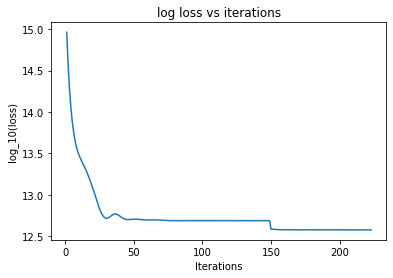

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.8028459548950195 seconds ---
SNR: 229.54019
Image 44 of 158
FWHM: 7.991464307212547
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 11
--- Time to move data onto GPU: 0.0003504753112792969 ---
Switching to Quasi-Newton step after 215 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.3969707489013672 seconds ---
Parameter containing:
tensor([2584.1665], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9233, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2584.16650390625


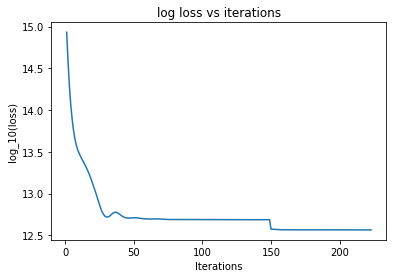

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5153980255126953 seconds ---
SNR: 265.07202
Image 45 of 158
FWHM: 8.560957886242576
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 8
--- Time to move data onto GPU: 0.00040602684020996094 ---
Switching to Quasi-Newton step after 220 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5242102146148682 seconds ---
Parameter containing:
tensor([2944.1064], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8372, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2944.1064453125


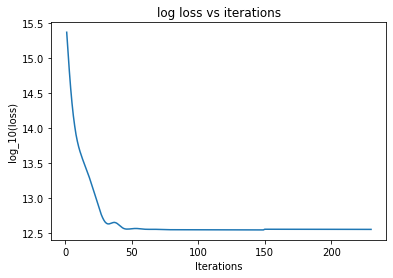

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6464803218841553 seconds ---
SNR: 189.18979
Image 46 of 158
FWHM: 6.573377223824831
N images: 1200.0
Aligning flat with (xs, ys) shifts: -9 10
--- Time to move data onto GPU: 0.0004036426544189453 ---
Switching to Quasi-Newton step after 213 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.361142635345459 seconds ---
Parameter containing:
tensor([2193.5183], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9199, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2193.518310546875


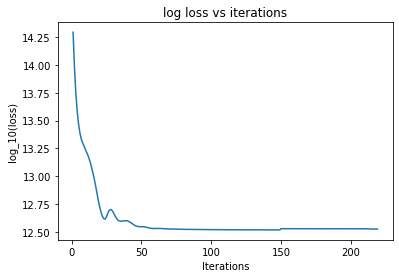

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.4882652759552002 seconds ---
SNR: 260.45987
Image 47 of 158
FWHM: 6.270632065384256
N images: 1200.0
Aligning flat with (xs, ys) shifts: 0 3
--- Time to move data onto GPU: 0.0003979206085205078 ---
Switching to Quasi-Newton step after 274 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.861814022064209 seconds ---
Parameter containing:
tensor([2443.8667], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9400, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2443.86669921875


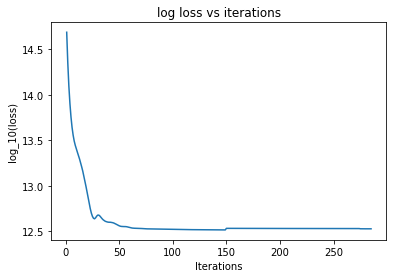

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.9843485355377197 seconds ---
SNR: 261.17325
Image 48 of 158
FWHM: 8.949124698802015
N images: 1200.0
Aligning flat with (xs, ys) shifts: -3 5
--- Time to move data onto GPU: 0.0003368854522705078 ---
Switching to Quasi-Newton step after 277 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.521275520324707 seconds ---
Parameter containing:
tensor([2075.6702], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9033, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2075.670166015625


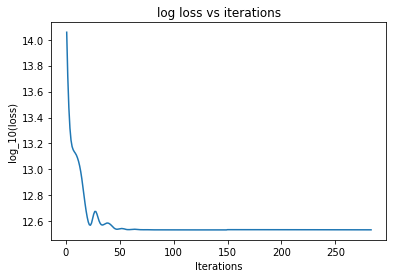

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.655808687210083 seconds ---
SNR: 233.27896
Image 49 of 158
FWHM: 7.113875931769205
N images: 1200.0
Aligning flat with (xs, ys) shifts: 5 12
--- Time to move data onto GPU: 0.00035691261291503906 ---
Switching to Quasi-Newton step after 245 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6066656112670898 seconds ---
Parameter containing:
tensor([2076.0576], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9353, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2076.0576171875


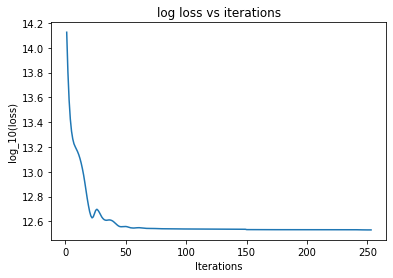

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.739434003829956 seconds ---
SNR: 261.9883
Image 50 of 158
FWHM: 10.99759659126143
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 3
--- Time to move data onto GPU: 0.0004558563232421875 ---
Switching to Quasi-Newton step after 201 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5558228492736816 seconds ---
Parameter containing:
tensor([2338.8325], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9250, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2338.83251953125


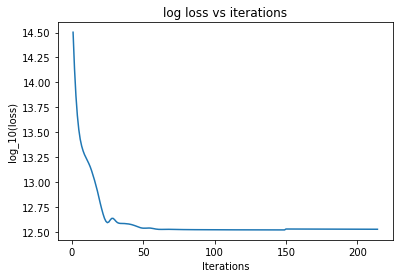

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6827096939086914 seconds ---
SNR: 242.95851
Image 51 of 158
FWHM: 8.260302407101774
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 9
--- Time to move data onto GPU: 0.00039076805114746094 ---
Switching to Quasi-Newton step after 216 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 0.9061870574951172 seconds ---
Parameter containing:
tensor([2629.3318], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8962, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2629.331787109375


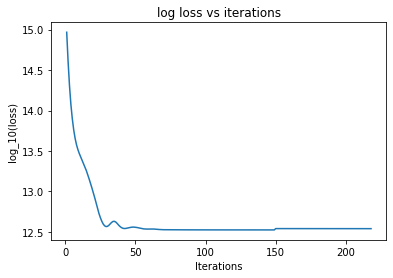

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.0308678150177002 seconds ---
SNR: 215.26494
Image 52 of 158
FWHM: 8.886594575966042
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 -2
--- Time to move data onto GPU: 0.00035190582275390625 ---
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 0.7726569175720215 seconds ---
Parameter containing:
tensor([2657.1343], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9258, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2657.13427734375


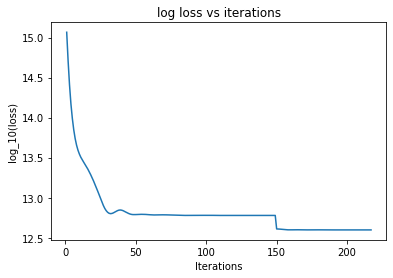

This version does not print parameter values vs iterations yet!
--- Finished in a total of 0.8966422080993652 seconds ---
SNR: 265.54434
Image 53 of 158
FWHM: 7.579721548163604
N images: 1200.0
Aligning flat with (xs, ys) shifts: 4 -1
--- Time to move data onto GPU: 0.00035858154296875 ---
Switching to Quasi-Newton step after 277 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7387759685516357 seconds ---
Parameter containing:
tensor([2381.9224], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9228, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2381.92236328125


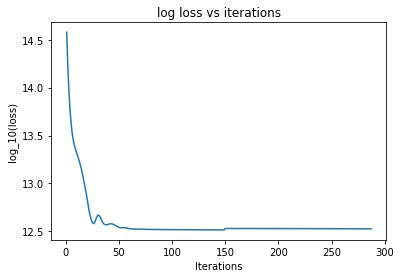

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.8622961044311523 seconds ---
SNR: 252.91068
Image 54 of 158
FWHM: 6.071107117984755
N images: 1200.0
Aligning flat with (xs, ys) shifts: 4 0
--- Time to move data onto GPU: 0.0003402233123779297 ---
Switching to Quasi-Newton step after 260 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7459852695465088 seconds ---
Parameter containing:
tensor([2299.8828], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9038, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2299.8828125


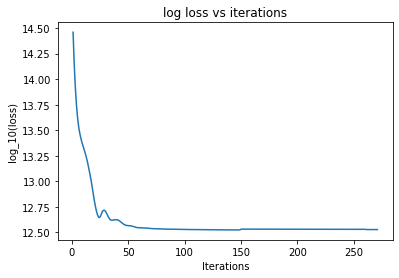

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.8803730010986328 seconds ---
SNR: 263.60074
Image 55 of 158
FWHM: 7.379115631519338
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 9
--- Time to move data onto GPU: 0.0003578662872314453 ---
Switching to Quasi-Newton step after 201 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5697038173675537 seconds ---
Parameter containing:
tensor([2259.7732], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8971, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2259.773193359375


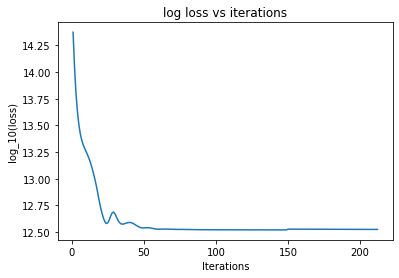

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.697035551071167 seconds ---
SNR: 248.09315
Image 56 of 158
FWHM: 6.628291725825639
N images: 1200.0
Aligning flat with (xs, ys) shifts: -7 1
--- Time to move data onto GPU: 0.00033020973205566406 ---
Switching to Quasi-Newton step after 253 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5815026760101318 seconds ---
Parameter containing:
tensor([3082.2383], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8139, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 3082.23828125


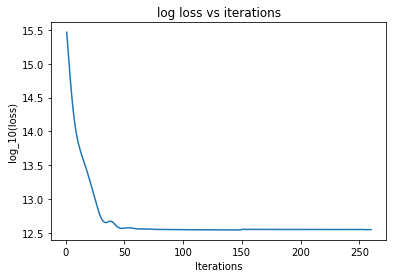

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7161273956298828 seconds ---
SNR: 198.49725
Image 57 of 158
FWHM: 8.694394402891676
N images: 1200.0
Aligning flat with (xs, ys) shifts: 5 5
--- Time to move data onto GPU: 0.00034499168395996094 ---
Switching to Quasi-Newton step after 233 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5172886848449707 seconds ---
Parameter containing:
tensor([2599.8228], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9075, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2599.82275390625


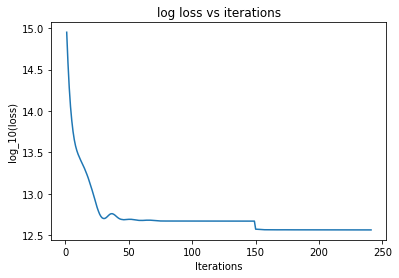

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6482429504394531 seconds ---
SNR: 251.26477
Image 58 of 158
FWHM: 7.207948471135193
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 6
--- Time to move data onto GPU: 0.0003361701965332031 ---
Switching to Quasi-Newton step after 207 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.3992359638214111 seconds ---
Parameter containing:
tensor([2052.7473], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9501, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2052.747314453125


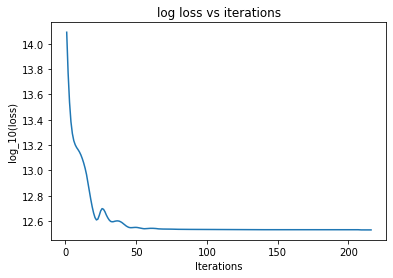

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5248541831970215 seconds ---
SNR: 265.45096
Image 59 of 158
FWHM: 8.674666999013468
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 2
--- Time to move data onto GPU: 0.0003533363342285156 ---
Switching to Quasi-Newton step after 215 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4539146423339844 seconds ---
Parameter containing:
tensor([2633.8945], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9249, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2633.89453125


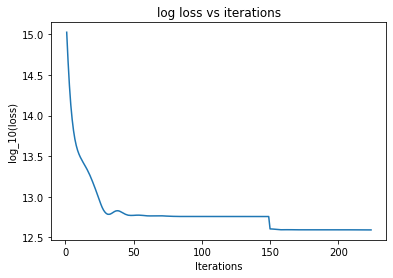

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5742669105529785 seconds ---
SNR: 261.62683
Image 60 of 158
FWHM: 7.481299807705788
N images: 1200.0
Aligning flat with (xs, ys) shifts: -2 8
--- Time to move data onto GPU: 0.00034499168395996094 ---
Switching to Quasi-Newton step after 201 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5228207111358643 seconds ---
Parameter containing:
tensor([2077.2312], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9547, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2077.231201171875


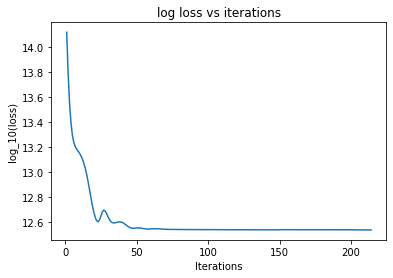

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.772292137145996 seconds ---
SNR: 259.14905
Image 61 of 158
FWHM: 7.190350271417405
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 -4
--- Time to move data onto GPU: 0.0003635883331298828 ---
Switching to Quasi-Newton step after 206 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4726760387420654 seconds ---
Parameter containing:
tensor([2789.0815], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9073, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2789.08154296875


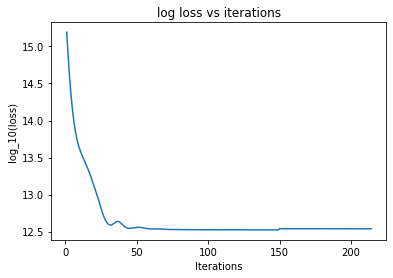

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5919208526611328 seconds ---
SNR: 224.387
Image 62 of 158
FWHM: 8.13885865621573
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 7
--- Time to move data onto GPU: 0.00035262107849121094 ---
Switching to Quasi-Newton step after 259 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5422770977020264 seconds ---
Parameter containing:
tensor([2748.6694], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9190, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2748.66943359375


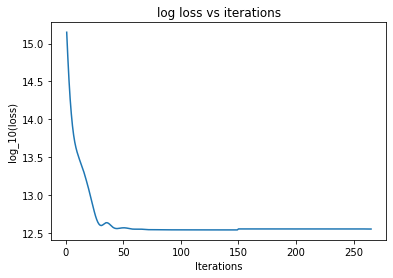

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6685459613800049 seconds ---
SNR: 212.44366
Image 63 of 158
FWHM: 8.159912763837077
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 2
--- Time to move data onto GPU: 0.0004096031188964844 ---
Switching to Quasi-Newton step after 213 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5846471786499023 seconds ---
Parameter containing:
tensor([2693.9875], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0352, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2693.987548828125


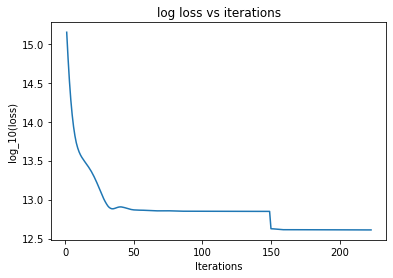

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7039568424224854 seconds ---
SNR: 321.8067
Image 64 of 158
FWHM: 9.451922273412864
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 8
--- Time to move data onto GPU: 0.0003204345703125 ---
Switching to Quasi-Newton step after 211 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.432314157485962 seconds ---
Parameter containing:
tensor([2599.6804], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8906, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2599.680419921875


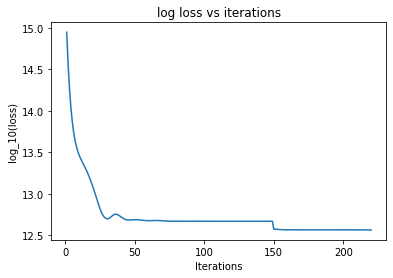

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5544641017913818 seconds ---
SNR: 241.29259
Image 65 of 158
FWHM: 7.736267965344858
N images: 1200.0
Aligning flat with (xs, ys) shifts: 6 3
--- Time to move data onto GPU: 0.0003590583801269531 ---
Switching to Quasi-Newton step after 202 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4142627716064453 seconds ---
Parameter containing:
tensor([2641.5156], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9771, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2641.515625


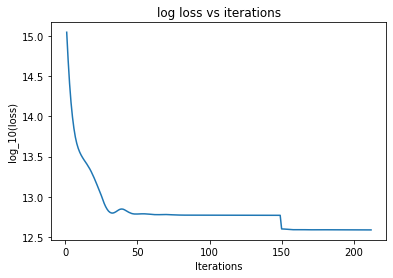

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.540137529373169 seconds ---
SNR: 294.75607
Image 66 of 158
FWHM: 6.769212992768437
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 -1
--- Time to move data onto GPU: 0.0003197193145751953 ---
Switching to Quasi-Newton step after 210 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5892112255096436 seconds ---
Parameter containing:
tensor([2080.8755], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9381, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2080.87548828125


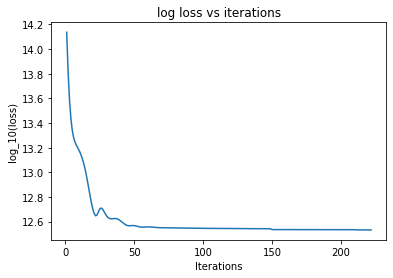

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.717155933380127 seconds ---
SNR: 261.59988
Image 67 of 158
FWHM: 5.418898253630654
N images: 1200.0
Aligning flat with (xs, ys) shifts: -10 -6
--- Time to move data onto GPU: 0.00042438507080078125 ---
Switching to Quasi-Newton step after 412 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.4751429557800293 seconds ---
Parameter containing:
tensor([2300.8657], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9140, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2300.86572265625


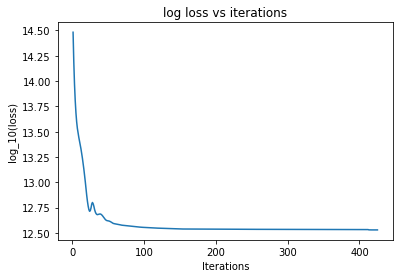

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.613738775253296 seconds ---
SNR: 277.03632
Image 68 of 158
FWHM: 7.25272819658846
N images: 1200.0
Aligning flat with (xs, ys) shifts: -7 11
--- Time to move data onto GPU: 0.00034499168395996094 ---
Switching to Quasi-Newton step after 202 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.3864033222198486 seconds ---
Parameter containing:
tensor([2150.3669], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9794, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2150.366943359375


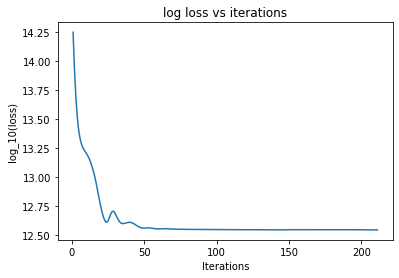

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5204226970672607 seconds ---
SNR: 264.76685
Image 69 of 158
FWHM: 8.367132077977587
N images: 1200.0
Aligning flat with (xs, ys) shifts: -5 5
--- Time to move data onto GPU: 0.0003497600555419922 ---
Switching to Quasi-Newton step after 325 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.9381163120269775 seconds ---
Parameter containing:
tensor([2250.9265], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9356, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2250.926513671875


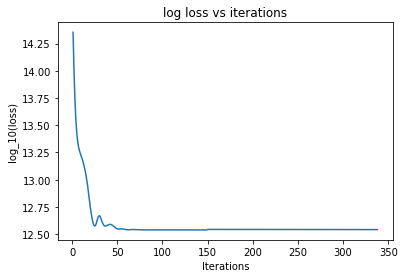

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.0785269737243652 seconds ---
SNR: 236.1572
Image 70 of 158
FWHM: 10.37025542032708
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 3
--- Time to move data onto GPU: 0.0003628730773925781 ---
Switching to Quasi-Newton step after 224 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4642629623413086 seconds ---
Parameter containing:
tensor([2337.3743], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9298, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2337.374267578125


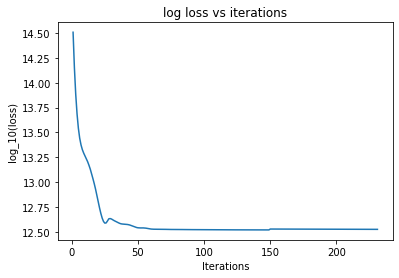

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.59580397605896 seconds ---
SNR: 252.32095
Image 71 of 158
FWHM: 4.708017653419864
N images: 1200.0
Aligning flat with (xs, ys) shifts: -3 -1
--- Time to move data onto GPU: 0.00036597251892089844 ---
Switching to Quasi-Newton step after 830 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.9450337886810303 seconds ---
Parameter containing:
tensor([2216.3315], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0150, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2216.33154296875


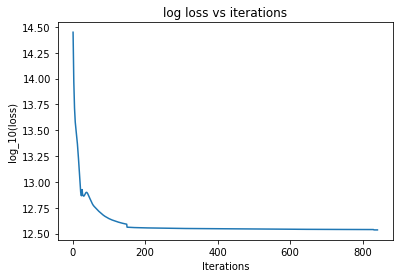

This version does not print parameter values vs iterations yet!
--- Finished in a total of 4.076879024505615 seconds ---
SNR: 343.50217
Image 72 of 158
FWHM: 8.29102718744208
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 10
--- Time to move data onto GPU: 0.00037860870361328125 ---
Switching to Quasi-Newton step after 238 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5981957912445068 seconds ---
Parameter containing:
tensor([2641.6416], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8968, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2641.6416015625


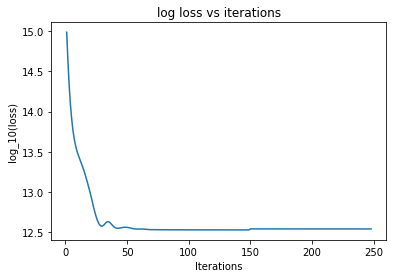

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7239534854888916 seconds ---
SNR: 214.83101
Image 73 of 158
FWHM: 8.159076468353419
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 1
--- Time to move data onto GPU: 0.0003159046173095703 ---
Switching to Quasi-Newton step after 358 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.9470312595367432 seconds ---
Parameter containing:
tensor([2739.9775], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9830, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2739.9775390625


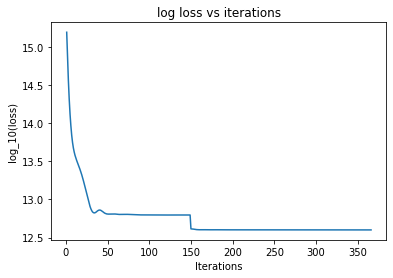

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.085286855697632 seconds ---
SNR: 288.2677
Image 74 of 158
FWHM: 9.022432637979932
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 2
--- Time to move data onto GPU: 0.0003273487091064453 ---
Switching to Quasi-Newton step after 219 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5413429737091064 seconds ---
Parameter containing:
tensor([2642.0212], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8757, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2642.021240234375


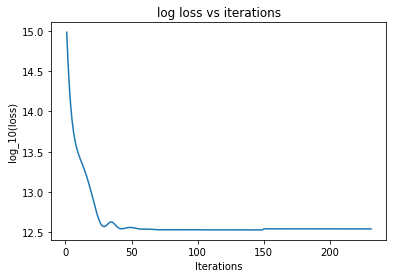

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.661963939666748 seconds ---
SNR: 202.69666
Image 75 of 158
FWHM: 7.84037713654008
N images: 1200.0
Aligning flat with (xs, ys) shifts: 0 7
--- Time to move data onto GPU: 0.00034689903259277344 ---
Switching to Quasi-Newton step after 205 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4488728046417236 seconds ---
Parameter containing:
tensor([2527.6582], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9298, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2527.658203125


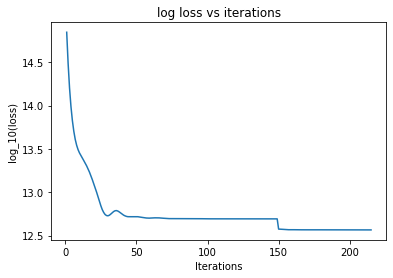

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.573085069656372 seconds ---
SNR: 273.59265
Image 76 of 158
FWHM: 9.019199613313035
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 5
--- Time to move data onto GPU: 0.0003421306610107422 ---
Switching to Quasi-Newton step after 283 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5287971496582031 seconds ---
Parameter containing:
tensor([2181.6462], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8819, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2181.646240234375


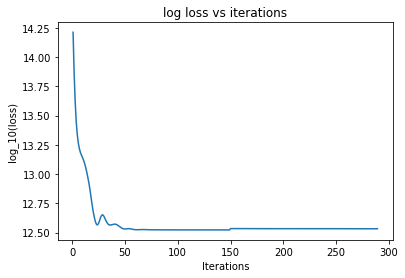

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6597940921783447 seconds ---
SNR: 230.53697
Image 77 of 158
FWHM: 8.31738625070034
N images: 1200.0
Aligning flat with (xs, ys) shifts: -7 10
--- Time to move data onto GPU: 0.00034117698669433594 ---
Switching to Quasi-Newton step after 282 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5060029029846191 seconds ---
Parameter containing:
tensor([2551.1851], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9272, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2551.18505859375


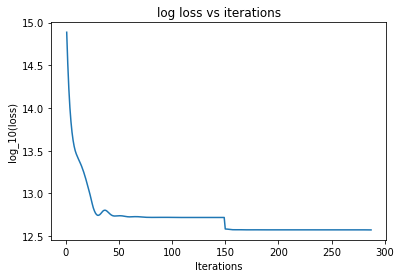

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.635148286819458 seconds ---
SNR: 269.67477
Image 78 of 158
FWHM: 8.910615972713037
N images: 1200.0
Aligning flat with (xs, ys) shifts: -3 2
--- Time to move data onto GPU: 0.00037217140197753906 ---
Switching to Quasi-Newton step after 232 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6788177490234375 seconds ---
Parameter containing:
tensor([2522.5881], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9085, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2522.588134765625


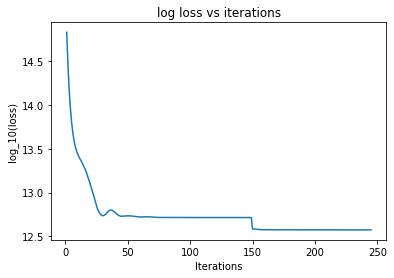

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.803621530532837 seconds ---
SNR: 260.73227
Image 79 of 158
FWHM: 10.00883214724477
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 12
--- Time to move data onto GPU: 0.00032901763916015625 ---
Switching to Quasi-Newton step after 291 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5178933143615723 seconds ---
Parameter containing:
tensor([2180.8723], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8591, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2180.872314453125


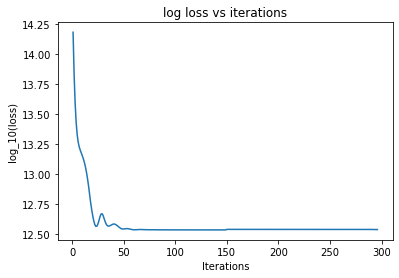

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6501266956329346 seconds ---
SNR: 205.65845
Image 80 of 158
FWHM: 7.884422274850126
N images: 1200.0
Aligning flat with (xs, ys) shifts: 6 7
--- Time to move data onto GPU: 0.0003745555877685547 ---
Switching to Quasi-Newton step after 303 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8020248413085938 seconds ---
Parameter containing:
tensor([2668.7778], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9123, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2668.77783203125


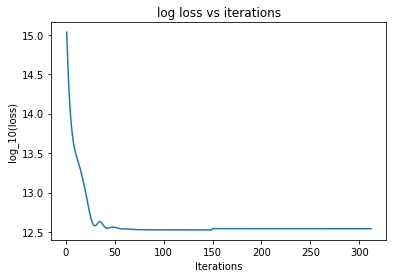

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.9270310401916504 seconds ---
SNR: 222.32687
Image 81 of 158
FWHM: 5.163515519935752
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 0
--- Time to move data onto GPU: 0.0003581047058105469 ---
Switching to Quasi-Newton step after 360 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.0694127082824707 seconds ---
Parameter containing:
tensor([2260.1594], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9595, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2260.159423828125


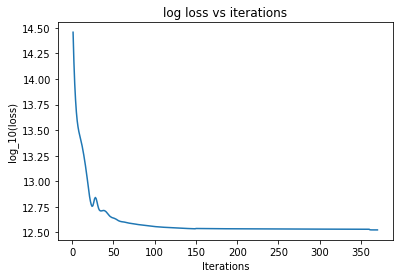

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.204716920852661 seconds ---
SNR: 306.8884
Image 82 of 158
FWHM: 6.259881837256741
N images: 1200.0
Aligning flat with (xs, ys) shifts: -6 3
--- Time to move data onto GPU: 0.0003502368927001953 ---
Switching to Quasi-Newton step after 268 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6449542045593262 seconds ---
Parameter containing:
tensor([2455.1108], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9609, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2455.11083984375


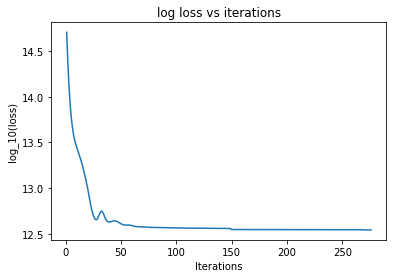

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7648863792419434 seconds ---
SNR: 262.2461
Image 83 of 158
FWHM: 7.754517603993582
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 4
--- Time to move data onto GPU: 0.0003361701965332031 ---
Switching to Quasi-Newton step after 289 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7448337078094482 seconds ---
Parameter containing:
tensor([2641.3176], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9200, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2641.317626953125


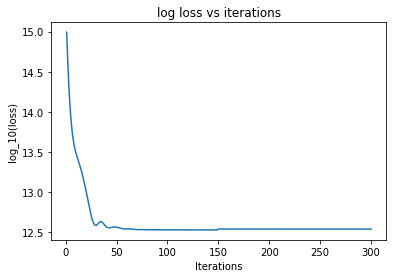

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.9964323043823242 seconds ---
SNR: 228.55411
Image 84 of 158
FWHM: 9.053140909224378
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 2
--- Time to move data onto GPU: 0.00032138824462890625 ---
Switching to Quasi-Newton step after 275 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7795031070709229 seconds ---
Parameter containing:
tensor([2152.0291], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8810, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2152.029052734375


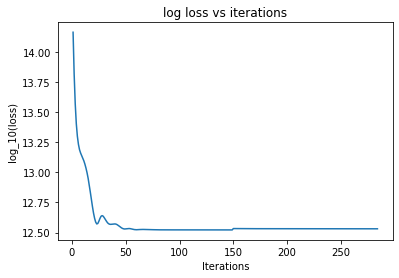

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.9055652618408203 seconds ---
SNR: 228.48529
Image 85 of 158
FWHM: 4.682137627543121
N images: 1200.0
Aligning flat with (xs, ys) shifts: 0 1
--- Time to move data onto GPU: 0.0003972053527832031 ---
Switching to Quasi-Newton step after 548 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.8560731410980225 seconds ---
Parameter containing:
tensor([2296.1492], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0194, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2296.149169921875


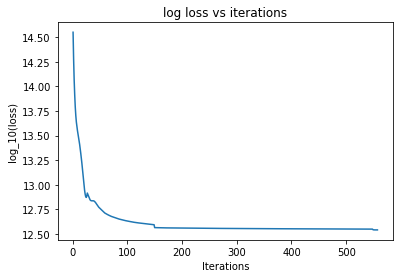

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.990145444869995 seconds ---
SNR: 340.47812
Image 86 of 158
FWHM: 5.990264802821087
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 4
--- Time to move data onto GPU: 0.0003311634063720703 ---
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.0648152828216553 seconds ---
Parameter containing:
tensor([2159.3394], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9597, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2159.33935546875


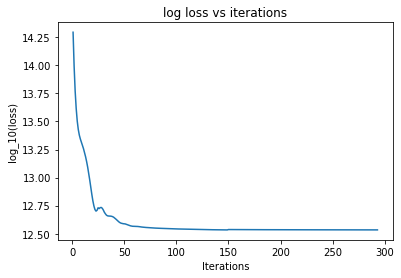

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.1962924003601074 seconds ---
SNR: 290.72345
Image 87 of 158
FWHM: 4.38517828465133
N images: 1200.0
Aligning flat with (xs, ys) shifts: -5 5
--- Time to move data onto GPU: 0.0003218650817871094 ---
Switching to Quasi-Newton step after 792 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.8032236099243164 seconds ---
Parameter containing:
tensor([2156.9768], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9852, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2156.976806640625


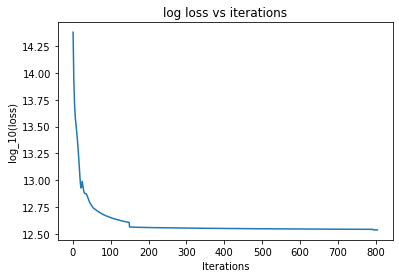

This version does not print parameter values vs iterations yet!
--- Finished in a total of 3.942467451095581 seconds ---
SNR: 352.63327
Image 88 of 158
FWHM: 14.08981066682347
N images: 1198.0
Aligning flat with (xs, ys) shifts: 9 -5
--- Time to move data onto GPU: 0.00032806396484375 ---
Switching to Quasi-Newton step after 6281 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 23.06757354736328 seconds ---
Parameter containing:
tensor([50990.9141], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8930, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 50990.9140625


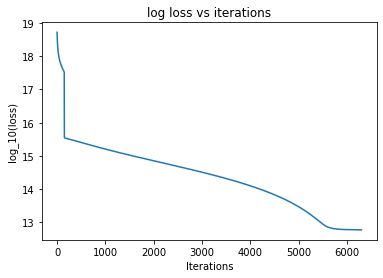

This version does not print parameter values vs iterations yet!
--- Finished in a total of 23.20439100265503 seconds ---
SNR: 45.76413
Image 89 of 158
FWHM: 4.935182602351889
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 2
--- Time to move data onto GPU: 0.00032806396484375 ---
Switching to Quasi-Newton step after 2368 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 9.597362995147705 seconds ---
Parameter containing:
tensor([2213.9653], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9602, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2213.96533203125


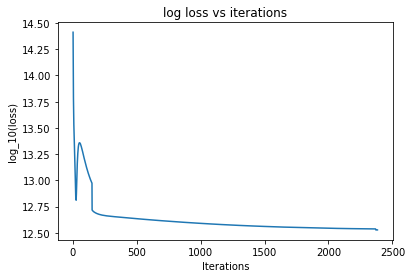

This version does not print parameter values vs iterations yet!
--- Finished in a total of 9.733035326004028 seconds ---
SNR: 317.74167
Image 90 of 158
FWHM: 4.343199253003089
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 0
--- Time to move data onto GPU: 0.00032401084899902344 ---
Switching to Quasi-Newton step after 738 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.6486763954162598 seconds ---
Parameter containing:
tensor([2329.2161], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0424, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2329.216064453125


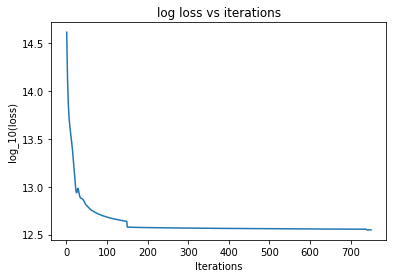

This version does not print parameter values vs iterations yet!
--- Finished in a total of 3.7813267707824707 seconds ---
SNR: 355.1614
Image 91 of 158
FWHM: 7.406638932213188
N images: 1200.0
Aligning flat with (xs, ys) shifts: 7 5
--- Time to move data onto GPU: 0.0003516674041748047 ---
Switching to Quasi-Newton step after 209 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.508331060409546 seconds ---
Parameter containing:
tensor([2533.0564], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9466, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2533.056396484375


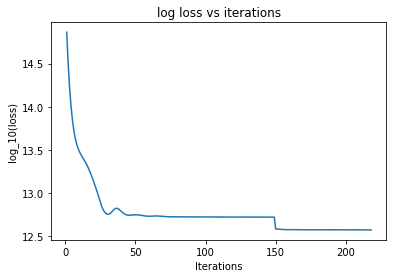

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6312096118927002 seconds ---
SNR: 290.37106
Image 92 of 158
FWHM: 6.803127515843242
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 -3
--- Time to move data onto GPU: 0.00033926963806152344 ---
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 0.7780675888061523 seconds ---
Parameter containing:
tensor([2265.4126], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9288, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2265.41259765625


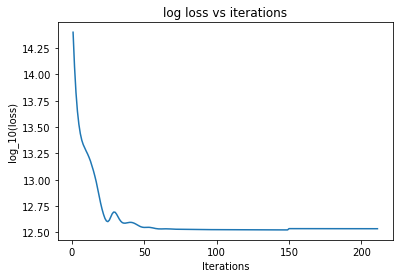

This version does not print parameter values vs iterations yet!
--- Finished in a total of 0.9080405235290527 seconds ---
SNR: 254.67885
Image 93 of 158
FWHM: 5.552302227742576
N images: 1200.0
Aligning flat with (xs, ys) shifts: 0 3
--- Time to move data onto GPU: 0.0003571510314941406 ---
Switching to Quasi-Newton step after 350 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.0021395683288574 seconds ---
Parameter containing:
tensor([2175.0232], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0086, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2175.023193359375


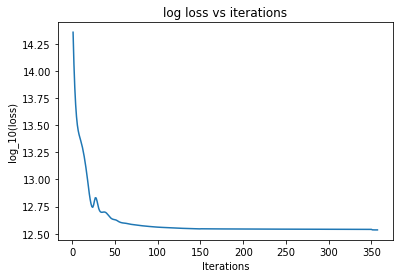

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.141418218612671 seconds ---
SNR: 311.52432
Image 94 of 158
FWHM: 9.110037869773242
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 3
--- Time to move data onto GPU: 0.0003254413604736328 ---
Switching to Quasi-Newton step after 203 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5472345352172852 seconds ---
Parameter containing:
tensor([2605.5864], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9870, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2605.58642578125


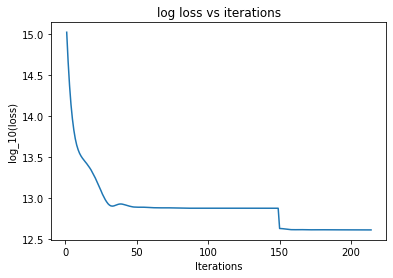

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6690466403961182 seconds ---
SNR: 306.07663
Image 95 of 158
FWHM: 6.013741846793167
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 3
--- Time to move data onto GPU: 0.0003566741943359375 ---
Switching to Quasi-Newton step after 339 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.0077779293060303 seconds ---
Parameter containing:
tensor([2062.1946], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9861, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2062.194580078125


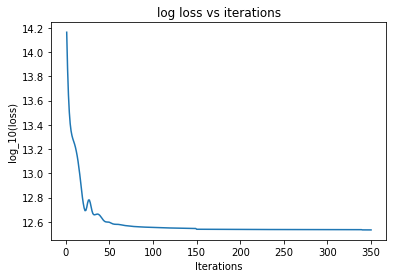

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.1497929096221924 seconds ---
SNR: 293.67825
Image 96 of 158
FWHM: 7.824793273276037
N images: 1199.0
Aligning flat with (xs, ys) shifts: 0 14
--- Time to move data onto GPU: 0.00032782554626464844 ---
Switching to Quasi-Newton step after 334 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6975393295288086 seconds ---
Parameter containing:
tensor([2057.3208], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9114, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2057.32080078125


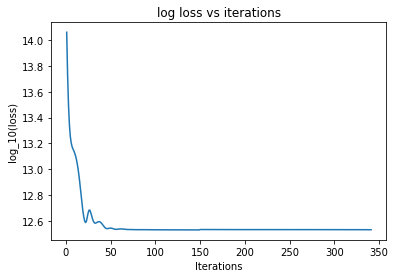

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.8318665027618408 seconds ---
SNR: 247.05984
Image 97 of 158
FWHM: 4.85751891129685
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 7
--- Time to move data onto GPU: 0.00035881996154785156 ---
Switching to Quasi-Newton step after 546 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.860342264175415 seconds ---
Parameter containing:
tensor([2378.5129], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0097, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2378.512939453125


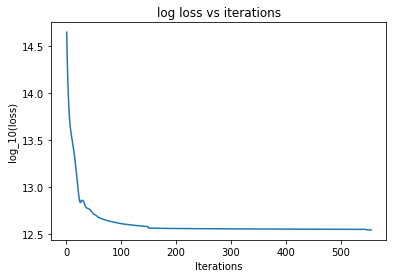

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.984234094619751 seconds ---
SNR: 322.74802
Image 98 of 158
FWHM: 9.208930832076556
N images: 1200.0
Aligning flat with (xs, ys) shifts: 0 8
--- Time to move data onto GPU: 0.00033974647521972656 ---
Switching to Quasi-Newton step after 257 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6068823337554932 seconds ---
Parameter containing:
tensor([2191.2048], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9177, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2191.204833984375


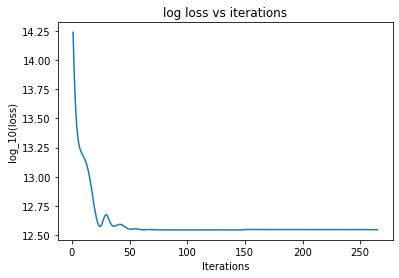

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7416396141052246 seconds ---
SNR: 224.44838
Image 99 of 158
FWHM: 8.457702799823332
N images: 1200.0
Aligning flat with (xs, ys) shifts: 4 7
--- Time to move data onto GPU: 0.0003483295440673828 ---
Switching to Quasi-Newton step after 312 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8089768886566162 seconds ---
Parameter containing:
tensor([2156.4065], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9545, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2156.406494140625


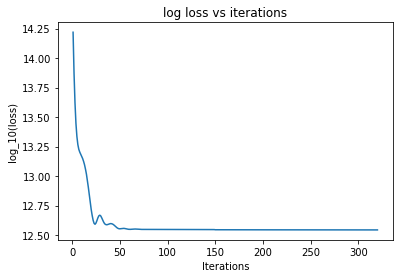

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.9444127082824707 seconds ---
SNR: 244.14816
Image 100 of 158
FWHM: 9.007793384592372
N images: 1200.0
Aligning flat with (xs, ys) shifts: -5 4
--- Time to move data onto GPU: 0.00032591819763183594 ---
Switching to Quasi-Newton step after 201 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4037280082702637 seconds ---
Parameter containing:
tensor([2366.6804], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8557, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2366.680419921875


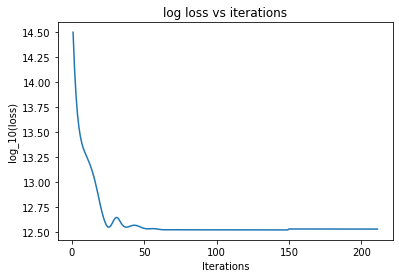

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5430231094360352 seconds ---
SNR: 211.27869
Image 101 of 158
FWHM: 5.058520476925191
N images: 1200.0
Aligning flat with (xs, ys) shifts: -4 -7
--- Time to move data onto GPU: 0.0003333091735839844 ---
Switching to Quasi-Newton step after 326 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.027395725250244 seconds ---
Parameter containing:
tensor([2256.2202], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9792, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2256.22021484375


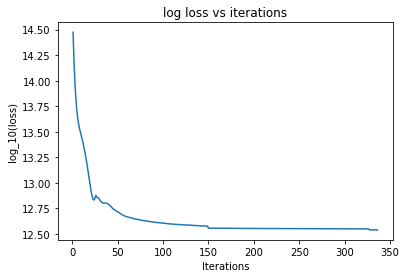

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.175220012664795 seconds ---
SNR: 318.5811
Image 102 of 158
FWHM: 8.711002107681326
N images: 1200.0
Aligning flat with (xs, ys) shifts: 5 0
--- Time to move data onto GPU: 0.0003349781036376953 ---
Switching to Quasi-Newton step after 206 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.648799180984497 seconds ---
Parameter containing:
tensor([2793.7148], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9151, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2793.71484375


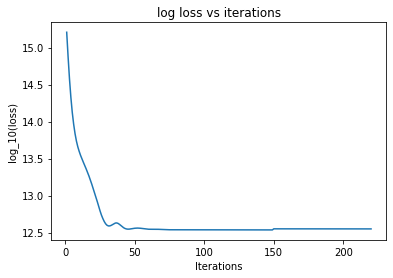

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7735803127288818 seconds ---
SNR: 206.04831
Image 103 of 158
FWHM: 8.489457751766402
N images: 1200.0
Aligning flat with (xs, ys) shifts: 7 2
--- Time to move data onto GPU: 0.00032782554626464844 ---
Switching to Quasi-Newton step after 206 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5508177280426025 seconds ---
Parameter containing:
tensor([2600.8599], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8915, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2600.85986328125


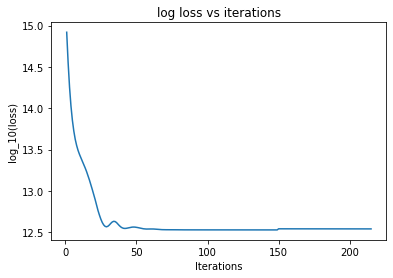

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.675487756729126 seconds ---
SNR: 212.02934
Image 104 of 158
FWHM: 4.454346337951599
N images: 1200.0
Aligning flat with (xs, ys) shifts: -2 9
--- Time to move data onto GPU: 0.00038743019104003906 ---
Switching to Quasi-Newton step after 759 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.675671100616455 seconds ---
Parameter containing:
tensor([2276.1172], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9962, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2276.1171875


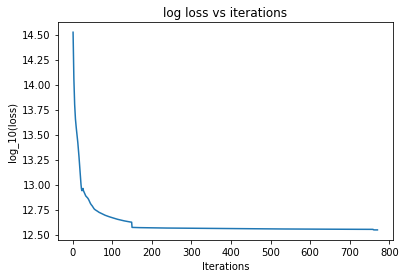

This version does not print parameter values vs iterations yet!
--- Finished in a total of 3.818366765975952 seconds ---
SNR: 337.64386
Image 105 of 158
FWHM: 8.009523411658108
N images: 1200.0
Aligning flat with (xs, ys) shifts: -3 9
--- Time to move data onto GPU: 0.0003390312194824219 ---
Switching to Quasi-Newton step after 205 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.601287603378296 seconds ---
Parameter containing:
tensor([2195.2163], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8862, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2195.21630859375


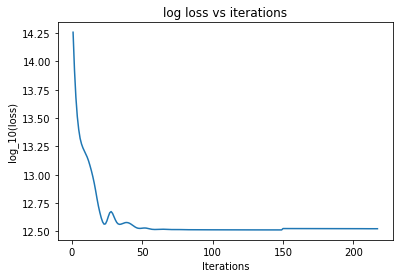

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.868898868560791 seconds ---
SNR: 241.63278
Image 106 of 158
FWHM: 8.780325642699905
N images: 1200.0
Aligning flat with (xs, ys) shifts: 6 6
--- Time to move data onto GPU: 0.0003745555877685547 ---
Switching to Quasi-Newton step after 264 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6628835201263428 seconds ---
Parameter containing:
tensor([2137.6738], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9417, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2137.673828125


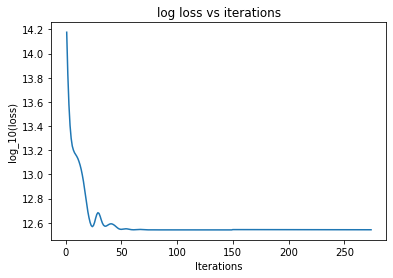

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7950124740600586 seconds ---
SNR: 239.61063
Image 107 of 158
FWHM: 5.667264377500006
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 -2
--- Time to move data onto GPU: 0.0003414154052734375 ---
Switching to Quasi-Newton step after 307 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.062171459197998 seconds ---
Parameter containing:
tensor([2480.2131], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9719, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2480.213134765625


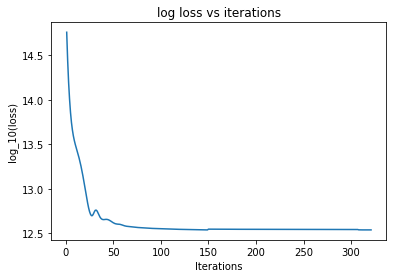

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.184644937515259 seconds ---
SNR: 278.73453
Image 108 of 158
FWHM: 4.318873184156446
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 2
--- Time to move data onto GPU: 0.0003674030303955078 ---
Switching to Quasi-Newton step after 725 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.7179934978485107 seconds ---
Parameter containing:
tensor([2311.0981], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9827, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2311.09814453125


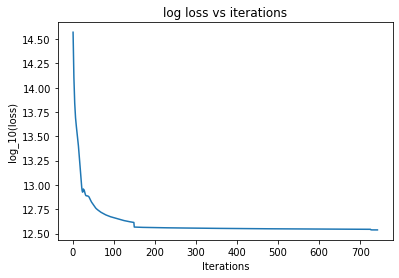

This version does not print parameter values vs iterations yet!
--- Finished in a total of 3.855689525604248 seconds ---
SNR: 343.14395
Image 109 of 158
FWHM: 8.312343742140403
N images: 1200.0
Aligning flat with (xs, ys) shifts: 0 5
--- Time to move data onto GPU: 0.00035500526428222656 ---
Switching to Quasi-Newton step after 236 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7061166763305664 seconds ---
Parameter containing:
tensor([2601.0259], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9053, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2601.02587890625


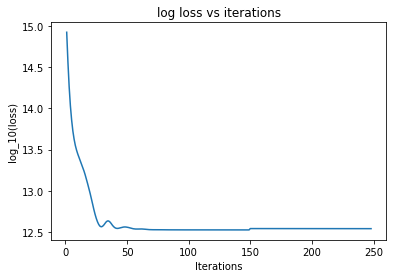

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.8417854309082031 seconds ---
SNR: 217.33575
Image 110 of 158
FWHM: 7.269950315654928
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 -8
--- Time to move data onto GPU: 0.0003917217254638672 ---
Switching to Quasi-Newton step after 215 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.3640227317810059 seconds ---
Parameter containing:
tensor([2643.0388], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9722, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2643.038818359375


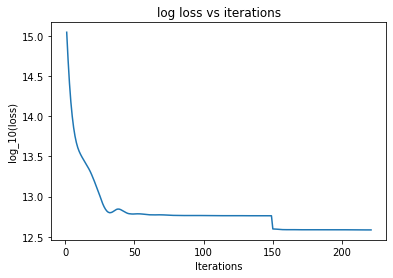

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.4911561012268066 seconds ---
SNR: 292.69833
Image 111 of 158
FWHM: 6.799465362217555
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 -4
--- Time to move data onto GPU: 0.000518798828125 ---
Switching to Quasi-Newton step after 214 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7774112224578857 seconds ---
Parameter containing:
tensor([2300.2070], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9712, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2300.20703125


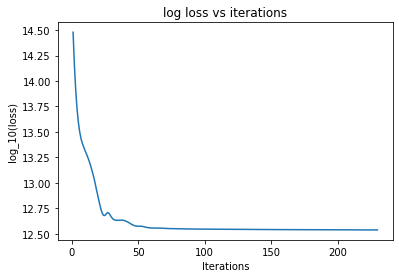

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.9108848571777344 seconds ---
SNR: 270.0592
Image 112 of 158
FWHM: 5.403859679001484
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 -9
--- Time to move data onto GPU: 0.00032591819763183594 ---
Switching to Quasi-Newton step after 453 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.4740958213806152 seconds ---
Parameter containing:
tensor([2388.4329], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9912, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2388.432861328125


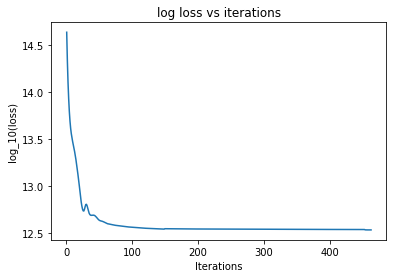

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.595479726791382 seconds ---
SNR: 303.26083
Image 113 of 158
FWHM: 6.00074405553943
N images: 1200.0
Aligning flat with (xs, ys) shifts: -3 -2
--- Time to move data onto GPU: 0.00034618377685546875 ---
Switching to Quasi-Newton step after 284 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.873004674911499 seconds ---
Parameter containing:
tensor([2434.9602], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9629, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2434.960205078125


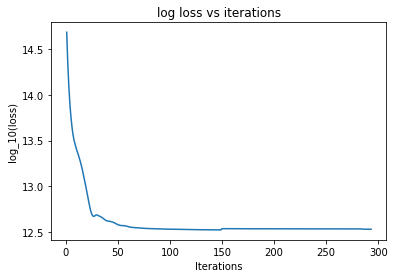

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.003098726272583 seconds ---
SNR: 271.38925
Image 114 of 158
FWHM: 4.699138540939013
N images: 1200.0
Aligning flat with (xs, ys) shifts: -10 5
--- Time to move data onto GPU: 0.0003159046173095703 ---
Switching to Quasi-Newton step after 533 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.9003841876983643 seconds ---
Parameter containing:
tensor([2507.6294], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9579, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2507.62939453125


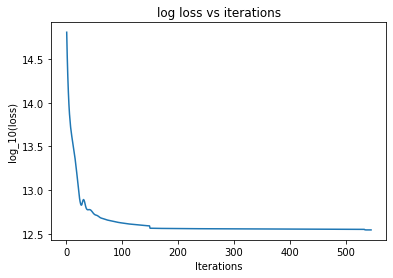

This version does not print parameter values vs iterations yet!
--- Finished in a total of 3.0259642601013184 seconds ---
SNR: 302.03506
Image 115 of 158
FWHM: 8.34090447596949
N images: 1200.0
Aligning flat with (xs, ys) shifts: -2 1
--- Time to move data onto GPU: 0.0004355907440185547 ---
Switching to Quasi-Newton step after 238 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5377559661865234 seconds ---
Parameter containing:
tensor([2792.9426], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9188, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2792.942626953125


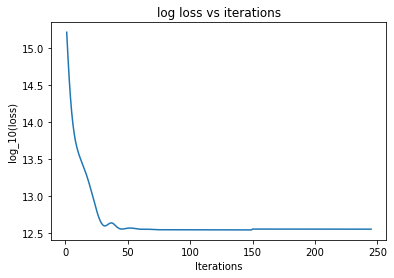

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6797795295715332 seconds ---
SNR: 209.18408
Image 116 of 158
FWHM: 5.457201396041697
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 1
--- Time to move data onto GPU: 0.00034546852111816406 ---
Switching to Quasi-Newton step after 426 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.562415599822998 seconds ---
Parameter containing:
tensor([2369.0356], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9773, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2369.03564453125


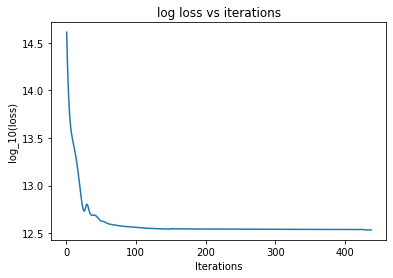

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.697472095489502 seconds ---
SNR: 298.97278
Image 117 of 158
FWHM: 6.955415955036498
N images: 1200.0
Aligning flat with (xs, ys) shifts: -9 10
--- Time to move data onto GPU: 0.00036787986755371094 ---
Switching to Quasi-Newton step after 255 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7159991264343262 seconds ---
Parameter containing:
tensor([2458.8074], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9388, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2458.807373046875


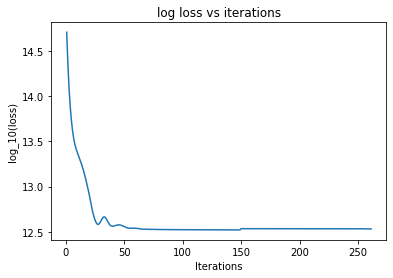

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.859715461730957 seconds ---
SNR: 249.62119
Image 118 of 158
FWHM: 4.967638935822046
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 5
--- Time to move data onto GPU: 0.000335693359375 ---
Switching to Quasi-Newton step after 532 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.1277146339416504 seconds ---
Parameter containing:
tensor([2271.2568], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9978, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2271.2568359375


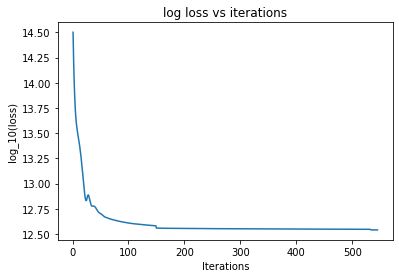

This version does not print parameter values vs iterations yet!
--- Finished in a total of 3.2945199012756348 seconds ---
SNR: 321.8339
Image 119 of 158
FWHM: 9.19034800015853
N images: 1200.0
Aligning flat with (xs, ys) shifts: 0 -1
--- Time to move data onto GPU: 0.00033402442932128906 ---
Switching to Quasi-Newton step after 264 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8672962188720703 seconds ---
Parameter containing:
tensor([2135.9695], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8830, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2135.969482421875


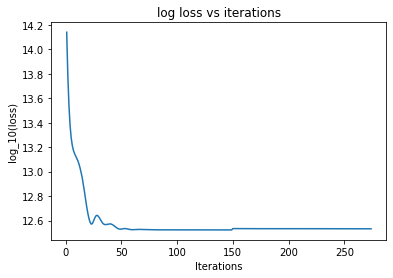

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.025296449661255 seconds ---
SNR: 228.49547
Image 120 of 158
FWHM: 7.815443905591378
N images: 1200.0
Aligning flat with (xs, ys) shifts: -6 0
--- Time to move data onto GPU: 0.0003769397735595703 ---
Switching to Quasi-Newton step after 226 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8811924457550049 seconds ---
Parameter containing:
tensor([4672.6816], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9208, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 4672.681640625


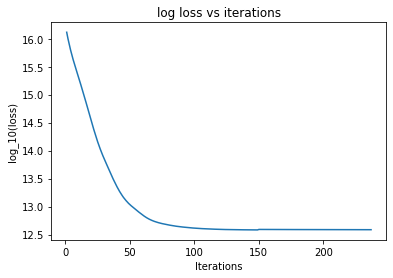

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.029627561569214 seconds ---
SNR: 158.91847
Image 121 of 158
FWHM: 9.643894087523577
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 1
--- Time to move data onto GPU: 0.000347137451171875 ---
Switching to Quasi-Newton step after 294 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.085496187210083 seconds ---
Parameter containing:
tensor([2122.0771], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8625, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2122.0771484375


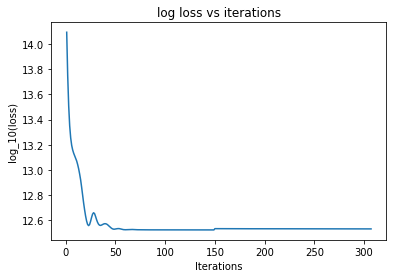

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.2391977310180664 seconds ---
SNR: 220.89594
Image 122 of 158
FWHM: 8.1445152734141
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 -1
--- Time to move data onto GPU: 0.00037407875061035156 ---
Switching to Quasi-Newton step after 212 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.511655569076538 seconds ---
Parameter containing:
tensor([2707.8459], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9803, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2707.845947265625


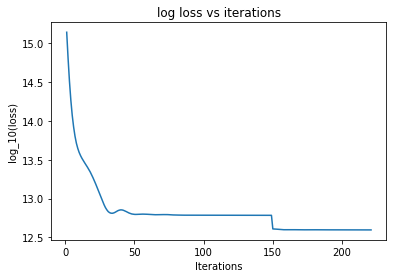

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.663823127746582 seconds ---
SNR: 286.09268
Image 123 of 158
FWHM: 4.906234231089567
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 3
--- Time to move data onto GPU: 0.0003516674041748047 ---
Switching to Quasi-Newton step after 470 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.6408257484436035 seconds ---
Parameter containing:
tensor([2238.1509], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9629, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2238.15087890625


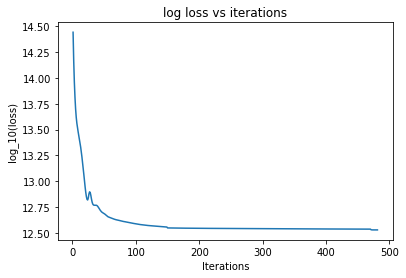

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.7764291763305664 seconds ---
SNR: 318.59918
Image 124 of 158
FWHM: 6.027180152476289
N images: 1200.0
Aligning flat with (xs, ys) shifts: -5 6
--- Time to move data onto GPU: 0.00035452842712402344 ---
Switching to Quasi-Newton step after 251 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.556065320968628 seconds ---
Parameter containing:
tensor([2222.5845], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9523, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2222.58447265625


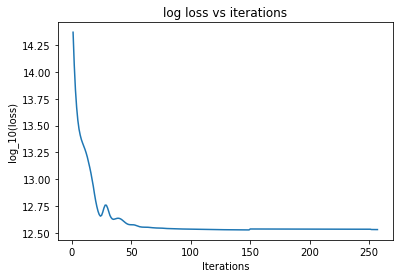

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6896605491638184 seconds ---
SNR: 280.12793
Image 125 of 158
FWHM: 7.467395042506837
N images: 1200.0
Aligning flat with (xs, ys) shifts: 0 -5
--- Time to move data onto GPU: 0.00034737586975097656 ---
Switching to Quasi-Newton step after 229 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6287498474121094 seconds ---
Parameter containing:
tensor([3910.5339], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9047, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 3910.533935546875


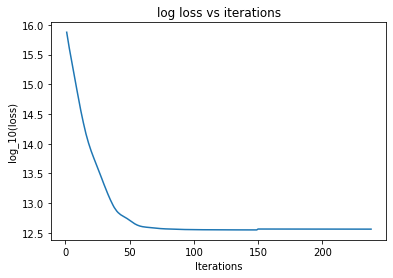

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7706665992736816 seconds ---
SNR: 184.78671
Image 126 of 158
FWHM: 6.709737779595508
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 -7
--- Time to move data onto GPU: 0.0003376007080078125 ---
Switching to Quasi-Newton step after 214 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4897522926330566 seconds ---
Parameter containing:
tensor([2545.2104], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9134, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2545.21044921875


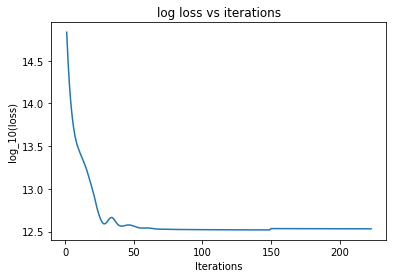

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6114656925201416 seconds ---
SNR: 241.75221
Image 127 of 158
FWHM: 8.20780116064958
N images: 1200.0
Aligning flat with (xs, ys) shifts: 5 2
--- Time to move data onto GPU: 0.0004229545593261719 ---
Switching to Quasi-Newton step after 241 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4393103122711182 seconds ---
Parameter containing:
tensor([2676.7532], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9091, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2676.753173828125


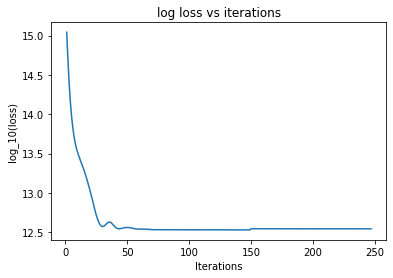

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5707488059997559 seconds ---
SNR: 212.04048
Image 128 of 158
FWHM: 5.946587432897712
N images: 1200.0
Aligning flat with (xs, ys) shifts: 0 -8
--- Time to move data onto GPU: 0.00033283233642578125 ---
Switching to Quasi-Newton step after 263 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7257423400878906 seconds ---
Parameter containing:
tensor([2815.3313], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9202, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2815.331298828125


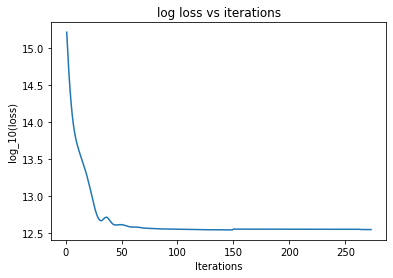

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.981473684310913 seconds ---
SNR: 244.41486
Image 129 of 158
FWHM: 5.637058052549086
N images: 1200.0
Aligning flat with (xs, ys) shifts: -2 7
--- Time to move data onto GPU: 0.0003266334533691406 ---
Switching to Quasi-Newton step after 368 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.162289619445801 seconds ---
Parameter containing:
tensor([2429.3779], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9987, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2429.3779296875


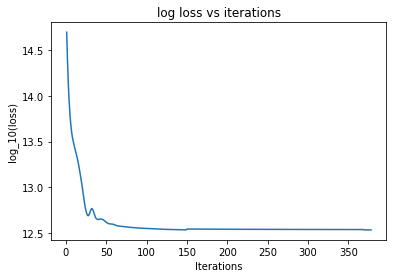

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.2918598651885986 seconds ---
SNR: 291.95895
Image 130 of 158
FWHM: 5.988440124949917
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 -3
--- Time to move data onto GPU: 0.0003345012664794922 ---
Switching to Quasi-Newton step after 334 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.989043951034546 seconds ---
Parameter containing:
tensor([2497.3860], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9381, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2497.385986328125


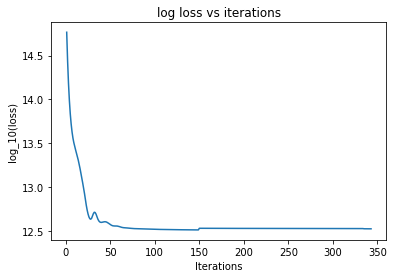

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.1341681480407715 seconds ---
SNR: 263.10883
Image 131 of 158
FWHM: 6.634054160202335
N images: 1200.0
Aligning flat with (xs, ys) shifts: 0 3
--- Time to move data onto GPU: 0.00038695335388183594 ---
Switching to Quasi-Newton step after 232 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.604607343673706 seconds ---
Parameter containing:
tensor([2623.1362], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9210, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2623.13623046875


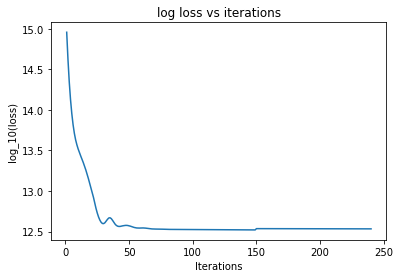

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7369990348815918 seconds ---
SNR: 244.04213
Image 132 of 158
FWHM: 8.782002143791654
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 9
--- Time to move data onto GPU: 0.0003650188446044922 ---
Switching to Quasi-Newton step after 206 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.3779497146606445 seconds ---
Parameter containing:
tensor([2508.8516], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9162, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2508.8515625


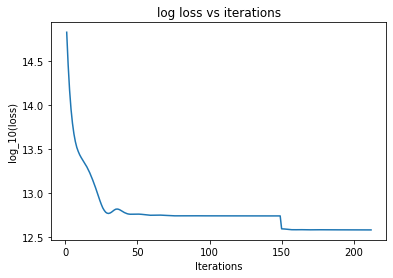

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.4971351623535156 seconds ---
SNR: 265.63083
Image 133 of 158
FWHM: 6.338934028098497
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 2
--- Time to move data onto GPU: 0.0003592967987060547 ---
Switching to Quasi-Newton step after 219 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4787657260894775 seconds ---
Parameter containing:
tensor([2018.5509], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9705, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2018.5509033203125


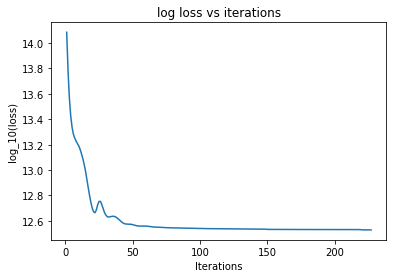

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.615309238433838 seconds ---
SNR: 286.77118
Image 134 of 158
FWHM: 6.188685743826056
N images: 1200.0
Aligning flat with (xs, ys) shifts: -9 0
--- Time to move data onto GPU: 0.0003561973571777344 ---
Switching to Quasi-Newton step after 225 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6170024871826172 seconds ---
Parameter containing:
tensor([2464.2683], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9412, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2464.268310546875


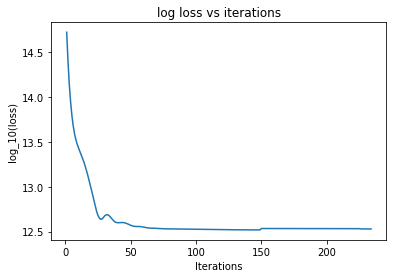

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7416634559631348 seconds ---
SNR: 264.93158
Image 135 of 158
FWHM: 9.241451391348509
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 2
--- Time to move data onto GPU: 0.0003418922424316406 ---
Switching to Quasi-Newton step after 237 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4534709453582764 seconds ---
Parameter containing:
tensor([2172.2451], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9182, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2172.2451171875


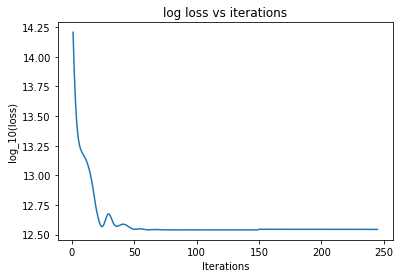

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5813446044921875 seconds ---
SNR: 226.09521
Image 136 of 158
FWHM: 7.248526292502835
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 0
--- Time to move data onto GPU: 0.0006792545318603516 ---
Switching to Quasi-Newton step after 228 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6277611255645752 seconds ---
Parameter containing:
tensor([2417.5530], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9157, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2417.552978515625


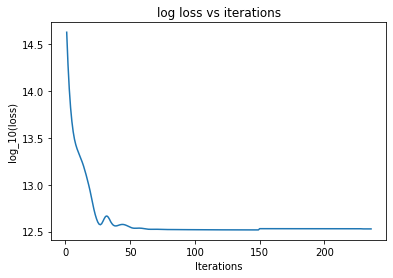

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7532484531402588 seconds ---
SNR: 247.01985
Image 137 of 158
FWHM: 5.785473467924933
N images: 1200.0
Aligning flat with (xs, ys) shifts: -4 6
--- Time to move data onto GPU: 0.0004277229309082031 ---
Switching to Quasi-Newton step after 318 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.0401389598846436 seconds ---
Parameter containing:
tensor([2165.0564], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9974, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2165.056396484375


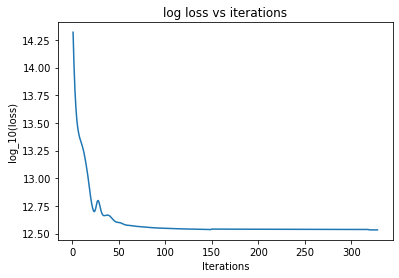

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.1802375316619873 seconds ---
SNR: 301.423
Image 138 of 158
FWHM: 6.705865267655411
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 -4
--- Time to move data onto GPU: 0.00033211708068847656 ---
Switching to Quasi-Newton step after 206 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7339372634887695 seconds ---
Parameter containing:
tensor([2104.1604], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9476, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2104.160400390625


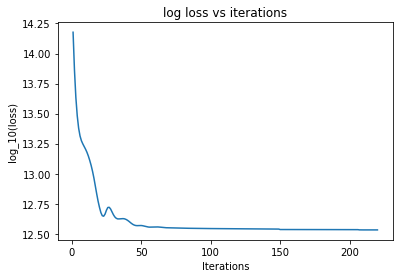

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.8716115951538086 seconds ---
SNR: 267.0446
Image 139 of 158
FWHM: 7.708164756103073
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 1
--- Time to move data onto GPU: 0.0003521442413330078 ---
Switching to Quasi-Newton step after 236 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5241737365722656 seconds ---
Parameter containing:
tensor([2598.2771], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9590, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2598.277099609375


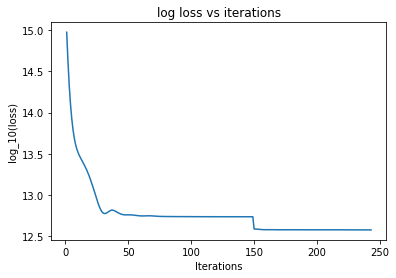

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.666109323501587 seconds ---
SNR: 287.4085
Image 140 of 158
FWHM: 5.283270470081565
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 3
--- Time to move data onto GPU: 0.0003161430358886719 ---
Switching to Quasi-Newton step after 353 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.0347132682800293 seconds ---
Parameter containing:
tensor([2457.2209], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9941, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2457.220947265625


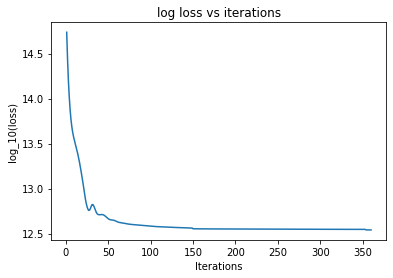

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.1690585613250732 seconds ---
SNR: 299.999
Image 141 of 158
FWHM: 7.957751040345475
N images: 1200.0
Aligning flat with (xs, ys) shifts: -2 7
--- Time to move data onto GPU: 0.0003142356872558594 ---
Switching to Quasi-Newton step after 315 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8005659580230713 seconds ---
Parameter containing:
tensor([2600.0759], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9174, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2600.075927734375


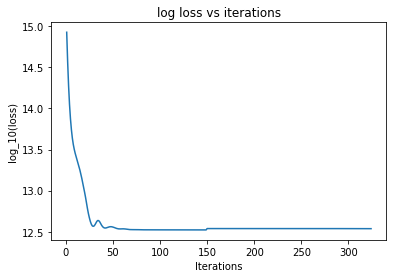

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.9302051067352295 seconds ---
SNR: 228.18219
Image 142 of 158
FWHM: 7.435997238362519
N images: 1200.0
Aligning flat with (xs, ys) shifts: 4 4
--- Time to move data onto GPU: 0.0003566741943359375 ---
Switching to Quasi-Newton step after 201 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.482893466949463 seconds ---
Parameter containing:
tensor([2361.1243], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9000, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2361.124267578125


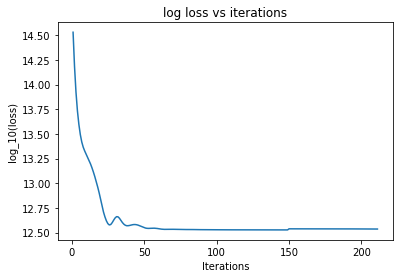

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.612318992614746 seconds ---
SNR: 241.76205
Image 143 of 158
FWHM: 8.131802956739898
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 6
--- Time to move data onto GPU: 0.00040340423583984375 ---
Switching to Quasi-Newton step after 220 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.535938024520874 seconds ---
Parameter containing:
tensor([2545.3491], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9238, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2545.34912109375


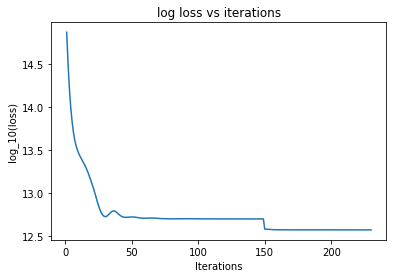

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6576967239379883 seconds ---
SNR: 271.03006
Image 144 of 158
FWHM: 5.842756011702354
N images: 1200.0
Aligning flat with (xs, ys) shifts: 2 2
--- Time to move data onto GPU: 0.00032019615173339844 ---
Switching to Quasi-Newton step after 270 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6397974491119385 seconds ---
Parameter containing:
tensor([2438.9028], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9639, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2438.90283203125


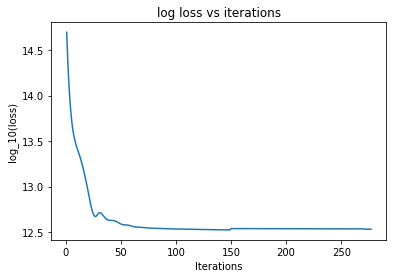

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7657201290130615 seconds ---
SNR: 275.39844
Image 145 of 158
FWHM: 5.279901032937739
N images: 1200.0
Aligning flat with (xs, ys) shifts: -7 5
--- Time to move data onto GPU: 0.0003490447998046875 ---
Switching to Quasi-Newton step after 444 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.3825643062591553 seconds ---
Parameter containing:
tensor([2553.1809], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9454, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2553.180908203125


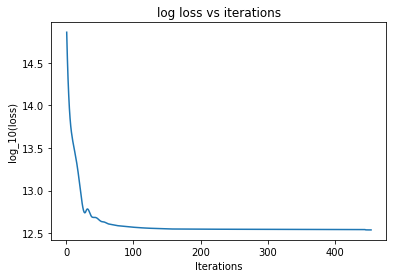

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.502657651901245 seconds ---
SNR: 278.38223
Image 146 of 158
FWHM: 6.959871100532627
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 -6
--- Time to move data onto GPU: 0.00033593177795410156 ---
Switching to Quasi-Newton step after 275 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6131870746612549 seconds ---
Parameter containing:
tensor([2625.0935], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9828, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2625.093505859375


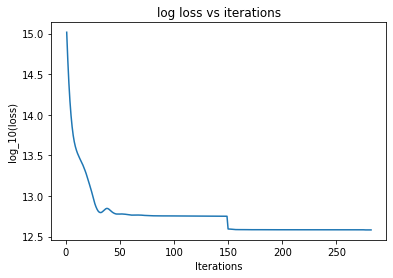

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7388405799865723 seconds ---
SNR: 302.84567
Image 147 of 158
FWHM: 8.423155805713318
N images: 1200.0
Aligning flat with (xs, ys) shifts: -4 7
--- Time to move data onto GPU: 0.0009307861328125 ---
Switching to Quasi-Newton step after 274 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6128191947937012 seconds ---
Parameter containing:
tensor([2704.8115], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9041, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2704.8115234375


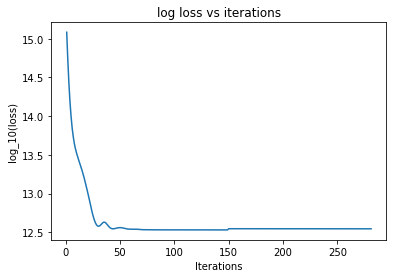

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7481825351715088 seconds ---
SNR: 208.14711
Image 148 of 158
FWHM: 4.546487439649048
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 -4
--- Time to move data onto GPU: 0.0003268718719482422 ---
Switching to Quasi-Newton step after 662 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.50612473487854 seconds ---
Parameter containing:
tensor([2300.2803], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0302, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2300.2802734375


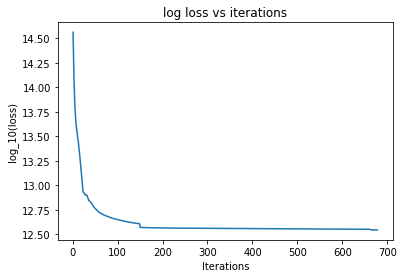

This version does not print parameter values vs iterations yet!
--- Finished in a total of 3.6581642627716064 seconds ---
SNR: 345.62286
Image 149 of 158
FWHM: 7.262665929565751
N images: 1200.0
Aligning flat with (xs, ys) shifts: -6 1
--- Time to move data onto GPU: 0.0003516674041748047 ---
Switching to Quasi-Newton step after 223 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8606288433074951 seconds ---
Parameter containing:
tensor([2251.9536], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9701, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2251.95361328125


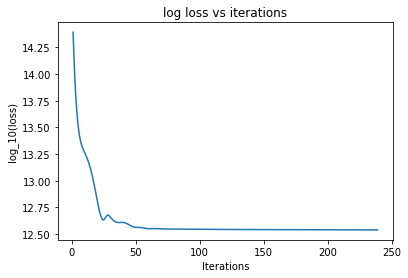

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.9974274635314941 seconds ---
SNR: 265.56662
Image 150 of 158
FWHM: 6.843683973127221
N images: 1200.0
Aligning flat with (xs, ys) shifts: -4 2
--- Time to move data onto GPU: 0.0003402233123779297 ---
Switching to Quasi-Newton step after 230 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4674439430236816 seconds ---
Parameter containing:
tensor([2980.7422], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8273, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2980.7421875


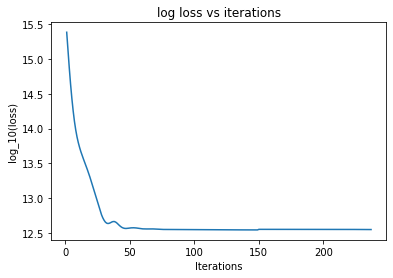

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.588629961013794 seconds ---
SNR: 201.5202
Image 151 of 158
FWHM: 10.0211541588603
N images: 1200.0
Aligning flat with (xs, ys) shifts: 5 0
--- Time to move data onto GPU: 0.0004062652587890625 ---
Switching to Quasi-Newton step after 206 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.490166425704956 seconds ---
Parameter containing:
tensor([2793.7556], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9259, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2793.755615234375


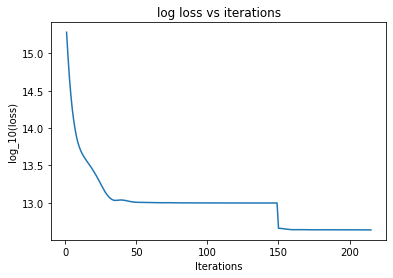

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7288193702697754 seconds ---
SNR: 309.3176
Image 152 of 158
FWHM: 8.000341990905056
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 0
--- Time to move data onto GPU: 0.00033473968505859375 ---
Switching to Quasi-Newton step after 215 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.479102373123169 seconds ---
Parameter containing:
tensor([2526.6086], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9414, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2526.608642578125


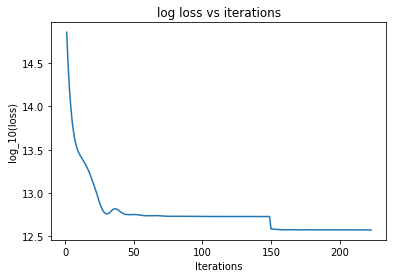

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5986943244934082 seconds ---
SNR: 283.06213
Image 153 of 158
FWHM: 6.27089307163268
N images: 1200.0
Aligning flat with (xs, ys) shifts: -2 6
--- Time to move data onto GPU: 0.0003781318664550781 ---
Switching to Quasi-Newton step after 203 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4486284255981445 seconds ---
Parameter containing:
tensor([3065.8694], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8213, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 3065.869384765625


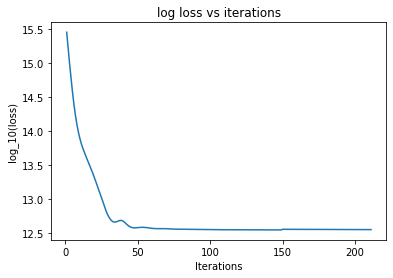

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.5827672481536865 seconds ---
SNR: 204.05284
Image 154 of 158
FWHM: 7.642024162286122
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 3
--- Time to move data onto GPU: 0.0003643035888671875 ---
Switching to Quasi-Newton step after 203 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5801639556884766 seconds ---
Parameter containing:
tensor([2199.9912], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8863, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2199.9912109375


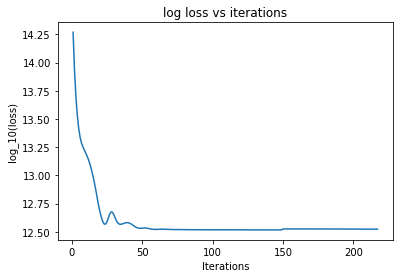

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.7094800472259521 seconds ---
SNR: 242.09706
Image 155 of 158
FWHM: 7.670957840684673
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 3
--- Time to move data onto GPU: 0.0004055500030517578 ---
Switching to Quasi-Newton step after 339 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.9433860778808594 seconds ---
Parameter containing:
tensor([2601.6694], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9165, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2601.66943359375


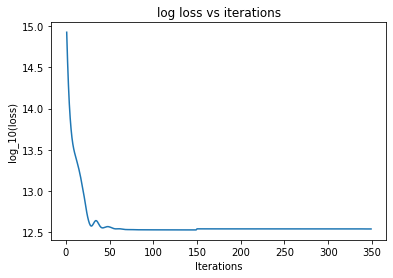

This version does not print parameter values vs iterations yet!
--- Finished in a total of 2.0740933418273926 seconds ---
SNR: 229.73222
Image 156 of 158
FWHM: 8.43328605021051
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 8
--- Time to move data onto GPU: 0.00042057037353515625 ---
Switching to Quasi-Newton step after 241 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6342930793762207 seconds ---
Parameter containing:
tensor([2676.1038], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9128, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2676.103759765625


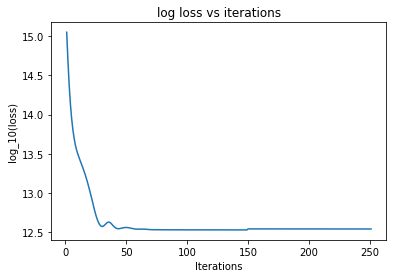

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.760925531387329 seconds ---
SNR: 215.31651
Image 157 of 158
FWHM: 6.966593657670675
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 3
--- Time to move data onto GPU: 0.0008604526519775391 ---
Switching to Quasi-Newton step after 202 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.549842357635498 seconds ---
Parameter containing:
tensor([2557.0164], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9694, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2557.016357421875


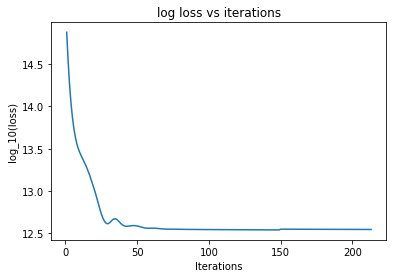

This version does not print parameter values vs iterations yet!
--- Finished in a total of 1.6729471683502197 seconds ---
SNR: 258.3185


In [ ]:
## run this cell once to load gpu, then run again for actual test
## gpu overhead associated with first loading it will screw with the
## actual solutiontimes for the very first image

# define function to return fit quality metrics
def metrics(M, I, noise_map, kernel_size, mask):
    
    # crop image edges to exlcude convolution artefacts
    M = M[kernel_size:M.shape[0]-kernel_size, kernel_size:M.shape[1]-kernel_size]
    I = I[kernel_size:I.shape[0]-kernel_size, kernel_size:I.shape[1]-kernel_size]
    noise_map = noise_map[kernel_size:noise_map.shape[0]-kernel_size, kernel_size:noise_map.shape[1]-kernel_size]
    mask = mask[kernel_size:mask.shape[0]-kernel_size, kernel_size:mask.shape[1]-kernel_size]
    
    # calculate metrics
    #x[~np.array(mask)]
    N_data = len(I[~mask].flatten())
    MFB = 1./(N_data) * np.sum((I - M)/noise_map)
    MFV = 1./(N_data - 1) * np.sum((((I - M)/noise_map) - MFB)**2)
    return MFB, MFV

# cutout stamp around position of selected stars
def make_stamp(image, pos, stamp_size):
    rad = np.int(stamp_size/2)
    x_centroid, y_centroid = pos[1], pos[0]
    x_max, x_min = x_centroid + rad, x_centroid - rad
    y_max, y_min = y_centroid + rad, y_centroid - rad
    stamp = image[x_min:x_max+1, y_min:y_max+1]
    return stamp

# cutout stamp around position of selected stars
def make_fit_cutout(image_stamp, c_size):
    centre = np.int(image_stamp.shape[0]/2)
    radius = np.int((c_size/2))
    cutout = image_stamp[centre - radius:centre + radius + 1, centre - radius:centre + radius + 1]
    return cutout

## sky subtract reference
ref -= np.median(ref)

## iterate through target images

#target_size = 100

times_to_kernel_solution = []
total_times = []
image_FWHMs = []
image_SNRs = []


start_time = time.time()

for i, image in enumerate(images):

    print('Image %d of %d' % (i, len(images)))
    print('FWHM:', FWHMs[i])
    print('N images:', N_images[i])

    file_name = fnames[i]
    xs, ys = shifts[:,1][np.where(shifts[:,0] == file_name)][0], shifts[:,2][np.where(shifts[:,0] == file_name)][0]
    print('Aligning flat with (xs, ys) shifts:',xs.astype(int), ys.astype(int))

    flat = shift(master_flat, (ys.astype(int),xs.astype(int)), cval=0.)
    flat = flat[crop:flat.shape[0]-crop, crop:flat.shape[1]-crop]

    SD_steps = 10000
    start_inf = time.time()
    '''
    kernel, B0, failed = PyTorchDIA_FullLikelihood.DIA(ref,
                                image,
                                flat, # flatfield
                                read_noise = 0.,
                                ks = 19,
                                lr_kernel = 1e-3,
                                lr_B = 1e1,
                                SD_steps = SD_steps,
                                Newton_tol = 1e-6,
                                poly_degree=0,
                                fast=True,
                                tol = 1e-9,
                                max_iterations = SD_steps + 25,
                                fisher=False,
                                show_convergence_plots=True)
    '''
    kernel, B0, failed = PyTorchDIA_RobustLoss_lossconv.DIA(ref,
                image,
                flat, # flatfield
                read_noise = 5.,
                ks = 19,
                lr_kernel = 1e-3,
                lr_B = 100,
                SD_steps = SD_steps,
                Newton_tol = 1e-6,
                poly_degree=0,
                fast=True,
                tol = 1e-9,
                max_iterations = SD_steps + 25,
                fisher=False,
                show_convergence_plots=True,
                c = 1.345)
    
    total_time = time.time() - start_inf
    

    
    # SNR calculation
    # model
    model = convolve2d(ref, kernel, mode='same') + B0
    # pixel uncertanties
    sigma0 = 2.55 # read noise
    #N = 1200 # number of images
    N = N_images[i]
    gain_CCD = 25.8 # CCD gain
    gain_EM = 300. # EM gain
    G = gain_CCD / gain_EM # Total gain
    excess_noise_factor = 2 # EMCCD fudge factor
    shot_noise = model/(G*flat)
    read_noise = N*sigma0**2 / flat**2
    #var_model = excess_noise_factor*(shot_noise + read_noise)
    var_model = excess_noise_factor*shot_noise
    pixel_uncertanties = np.sqrt(var_model) # Noise Model

    #plt.imshow(pixel_uncertanties)
    #plt.colorbar()
    #plt.show()

    sky = np.median(image)
    SNR = np.sum(image - sky) / np.sqrt(np.sum(pixel_uncertanties**2))
    print('SNR:', SNR)

    # image parameter info
    image_FWHMs.append(FWHMs[i]) 
    image_SNRs.append(SNR)
    
    # time to solution
    total_times.append(total_time)

    

#print(len(MFBs), len(MFVs), len(Ps_normalised), len(norm_phot_resids))
#print('Total time:', time.time() - start_time)

Text(0, 0.5, 'Image SNR')

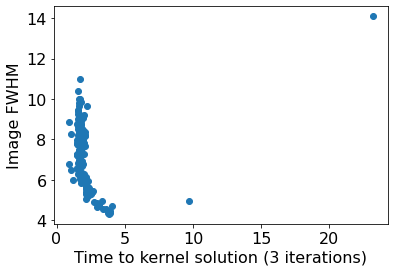

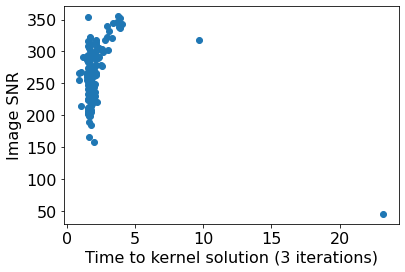

In [ ]:
## plots
fontsize = 16

plt.figure()
plt.scatter(total_times, image_FWHMs)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Time to kernel solution (3 iterations)', fontsize=fontsize)
plt.ylabel('Image FWHM', fontsize=fontsize)

plt.figure()
plt.scatter(total_times, image_SNRs)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Time to kernel solution (3 iterations)', fontsize=fontsize)
plt.ylabel('Image SNR', fontsize=fontsize)

In [ ]:
# other metrics info
print(len(total_times), len(image_FWHMs), len(image_SNRs))
print('Median solution time:', np.median(total_times))
print('Median FWHM:', np.median(image_FWHMs))
print('Median SNR:', np.median(image_SNRs))


158 158 158
Median solution time: 1.739341139793396
Median FWHM: 7.478626311636683
Median SNR: 261.80756


In [ ]:
out = np.vstack((total_times, image_FWHMs, image_SNRs)).T
print(out.shape)
np.savetxt(os.path.join(path,'performance_data_212x212_19x19_no_read_noise_fullLL_robust_lossconv.txt'), out)

(158, 3)


In [ ]:
    '''
    ### pyDANDIA ###
    pyDANDIA_start = time.time()

    ss = 19

    mask = np.zeros(image.shape)


    for iters in range(0, 3):
        
        # pixel uncertanties
        sigma0 = 2.55 # read noise
        N = N_images[i] # number of images
        gain_CCD = 25.8 # CCD gain
        gain_EM = 300. # EM gain
        G = gain_CCD / gain_EM # Total gain
        excess_noise_factor = 2 # EMCCD fudge factor
        if iters == 0:
            shot_noise = image/(G*flat)
        else:
            shot_noise = model/(G*flat)   
        read_noise = N*sigma0**2 / flat**2
        var_model = excess_noise_factor*(shot_noise + read_noise)
        pixel_uncertanties = np.sqrt(var_model) 
        
        # Noise Model
        weights = 1./var_model
        # mask outliers
        weights[np.where(mask == 1)] = 1e-198
        print('\nMasked pixels (pyDANDIA):', np.sum(mask))
        print('\npyDANDIA solution, iter %d' % iters)
        ext_ref = extend_image(ref, ss)
        ext_imag = extend_image(image, ss)
        ext_weights = extend_image(weights, ss)

        U, b = construct_kernel_and_matrices(ss, ext_ref, ext_imag, ext_weights)
        kernel, B0 = lstsq_solution(ext_ref, ext_imag, U, b, ss)
        print('P:', np.sum(kernel))
        print('B0:', B0)
        start_conv2d = time.time()
        model = convolve2d(ref, kernel, mode='same') + B0
        print('Conv2d time:', time.time() - start_conv2d)
        print('weights shape:', weights.shape)
        print('image shape:', image.shape)
        print('model:', model.shape)
        norm_resids = np.sqrt(weights)*(image - model)
        mask[np.where(np.abs(norm_resids)>1e99)] = 1
        
        print('Sum abs(norm_resids):', np.sum(np.abs(norm_resids)))
        '''
        '''
        plt.figure(figsize=(5,5))
        plt.hist(norm_resids.flatten(), bins='auto', density=True)
        #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        x = np.linspace(-5, 5, 100)
        plt.plot(x, norm.pdf(x, 0, 1))
        plt.xlim(-5, 5)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.xlabel('Normalised residuals', fontsize=20)
        plt.ylabel('Probability', fontsize=20)
        #plt.savefig(os.path.join(path, 'NormalisedResids.png'), bbox_inches='tight', overwrite=True)
        plt.show()
        '''
        '''
    # solution time
    #times_to_kernel_solution.append(solve_times)
    total_time = time.time() - pyDANDIA_start
    total_times.append(total_time)
    print('pyDANDIA time:', total_time)

    '''